# EBM Project Notebook
Now that we have learned how to use the EBM package, we are going to 
take the ADNI data set that we cleaned from the last project notebook
and use it to replicate the results from the brain paper from Alex Young.

As a reminder, here are the features we are going to use:
* Cerebrospinal Fluid (CSF) INNO-BIA AlzBio3 immunoassay ('INNO')
  * Amyloid Beta 1-42
  * phosphorylated tau - log transformed to improve normality
  * total tau - log transformed to improve normality
* Volumetric measurements from **1.5T** magnetic resonance imaging (MRI), 
normalised by dividing by Intracranial Volume (ICV)
  * Whole brain volume
  * Ventricular volume
  * Entorhinal cortex volume
  * Hippocampal volume
  * Middle temporal cortex volume
  * Fusiform cortex volume 
* Direct measurements of atrophy between two timepoints using volumetric MRI
  * Annualised whole brain atrophy between 0 and **12 months** using Boundary Shift Integral (BSI)
  * Annualised hippocampal atrophy between 0 and **12 months** using Boundary Shift Integral (BSI)
* Cognitive measures
  * Mini mental state examination (MMSE)
  * ADAS-COG13
  * Rey Auditory Verbal Learning Test (RAVLT)

In [1]:
# Put any import steps that you want to keep here
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from kde_ebm.mixture_model import fit_all_kde_models, fit_all_gmm_models
from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram
from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures

plt.rcParams.update({'font.size': 18}) # default fontsize

## Step 1 - Open the data
First up, load up the spreadsheet that you created from the second project notebook.

In [2]:
# Your answer to Step 1
# Below put your code that will load in the data that you created from the ADNI data
adni_data = pd.read_csv('../clean_ebm_data.csv')

## Step 2 - Initial Processing of data
Our spreadsheets from the first exercise still need a few more tweaks before running the EBM.

Our current MRI features are the raw volumes. However, the volume of most brain structures are highly associated with the head size of the individual. We have a good proxy variable of head size extracted from the image data called *total intracranial volume* or TIV. In order to reduce the effect of head size, Young *et al.* divided all of the brain structures by TIV before putting it into the EBM. So remember to do the same with your features. 
However, there are two exceptions. The *boundary shift integral* or BSI measures do not measure the size of the brain structure but how much the size has **changed** over one year. These changes have not been shown to be associated with TIV and so they **do not** need to be normalised by TIV before the EBM.

We will discuss this further in future steps, but we need to have a column that provides a special coding of the three values in the baseline diagnosis (`DX_bl`) column, where:
* Cognitively Normal (CN) = 0
* Alzheimer's Disease (AD) = 1
* Mild Cognitive Impairment (LMCI) = 2

Also, I would suggest to make some Python lists to help hold key sets of column names:
* Key *metadata* that are helpful for processing but not going to be in the EBM, and 
* names of *features* that you want to include in the EBM ordering. 

In [3]:
# Normalize volumes
adni_proc = adni_data.copy()
adni_proc['hippo_norm'] = adni_proc['Hippocampus']/adni_proc['WholeBrain']
adni_proc['mtc_norm'] = adni_proc['MidTemp']/adni_proc['WholeBrain']
adni_proc['fusiform_norm'] = adni_proc['Fusiform']/adni_proc['WholeBrain']
adni_proc['ec_norm'] = adni_proc['Entorhinal']/adni_proc['WholeBrain']
adni_proc['ventricles_norm'] = adni_proc['Ventricles']/adni_proc['WholeBrain']

# Log transform Tau values
adni_proc['log_ptau'] = np.log(adni_proc['PTAU_INNO'])
adni_proc['log_tau'] = np.log(adni_proc['TAU_INNO'])

# Convert diagnosis to numeric
adni_proc['dx'] = adni_proc['DX_bl'].astype("category")
adni_proc.dx.cat.reorder_categories(['CN', 'AD', 'LMCI'], inplace = True)
adni_proc['dx_num'] = adni_proc['dx'].replace(['CN', 'AD', 'LMCI'], [0, 1, 2])

# List creation
feats = ['ABETA_INNO', 'log_ptau', 'log_tau',
        'ventricles_norm', 'hippo_norm', 'fusiform_norm', 'ec_norm', 'mtc_norm',
        'ANN_BBSI', 'ANN_HBSI',
        'MMSE', 'RAVLT_immediate', 'ADAS13']

metadata = ['AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'APOE4']

## Step 3 - Visualise distributions of features
For each of the features, produce a plot showing the difference between the CN, LMCI, and AD groups.

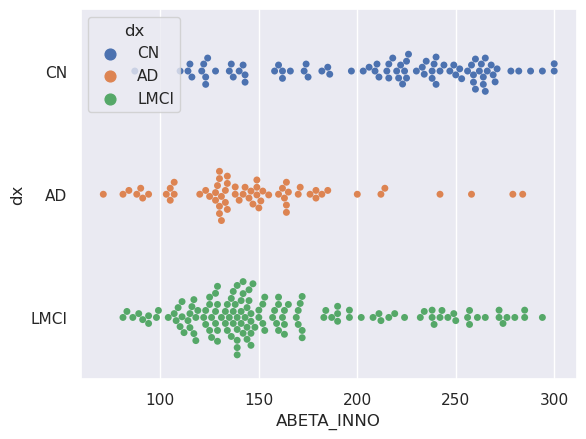

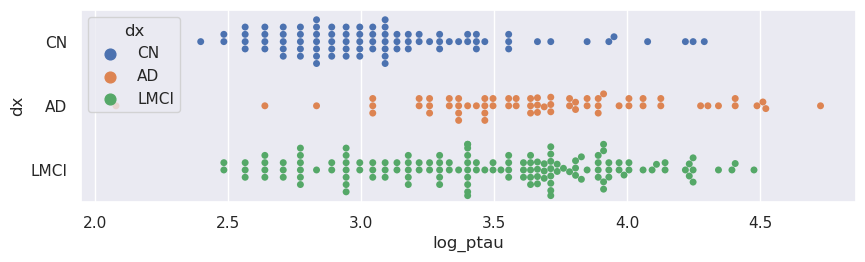

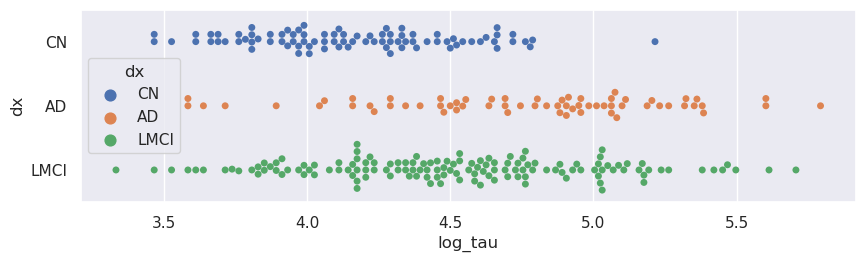

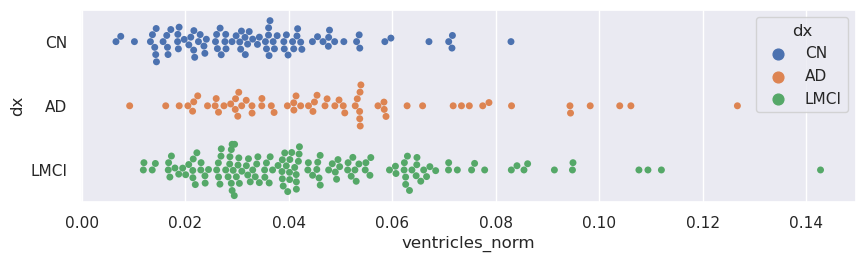

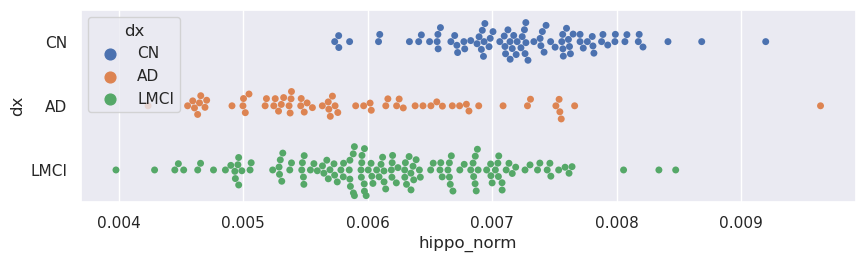

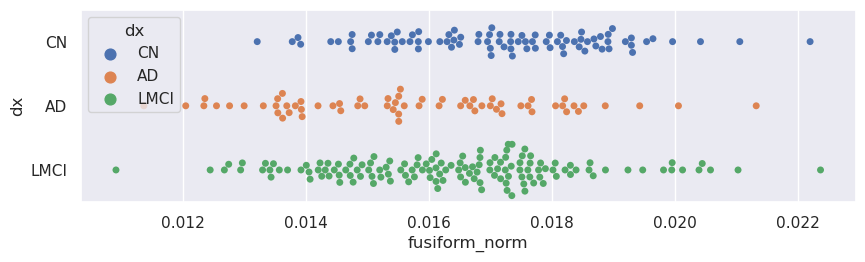

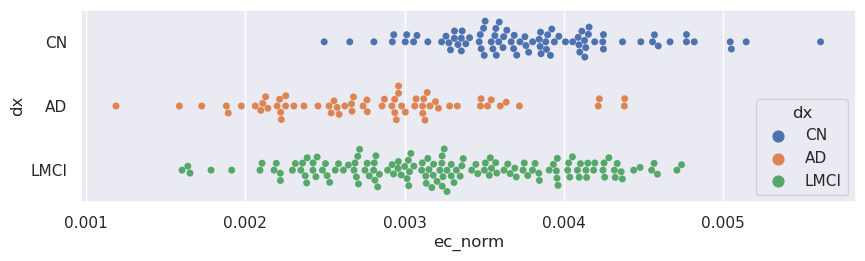

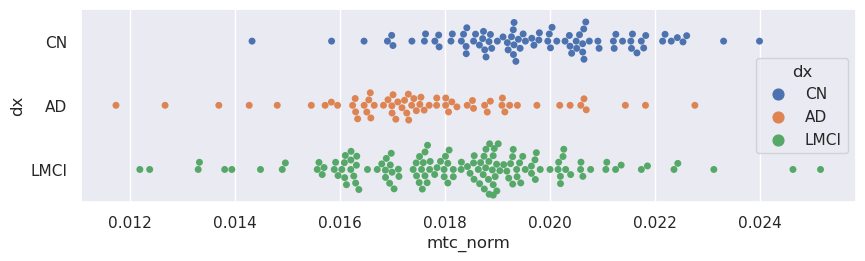

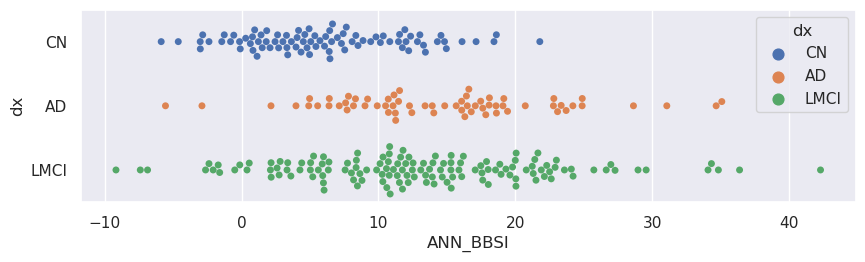

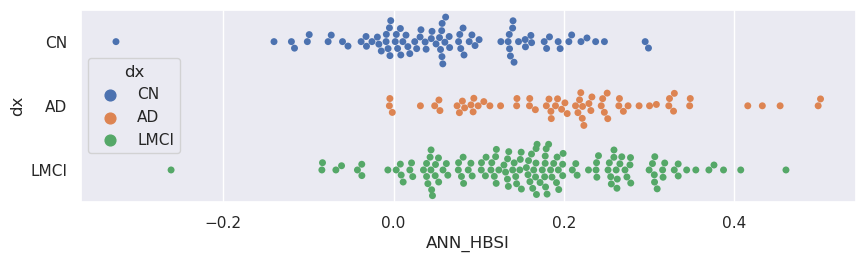

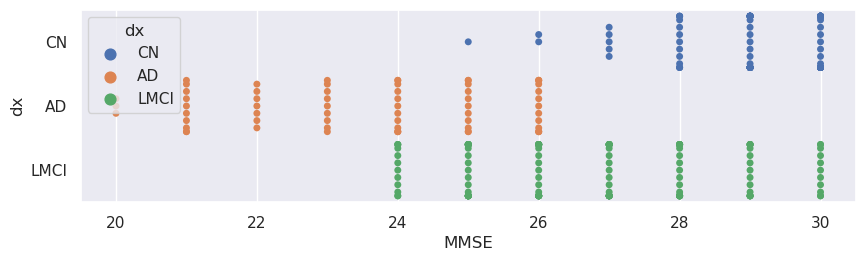

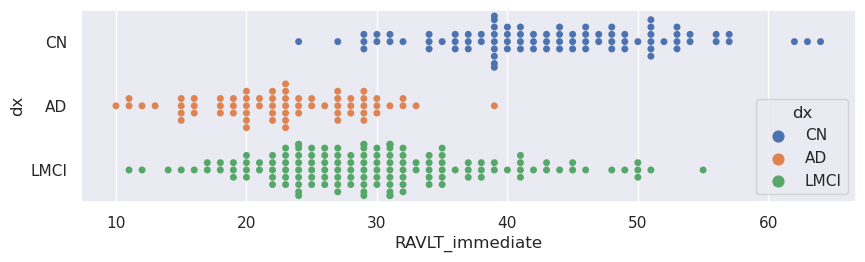

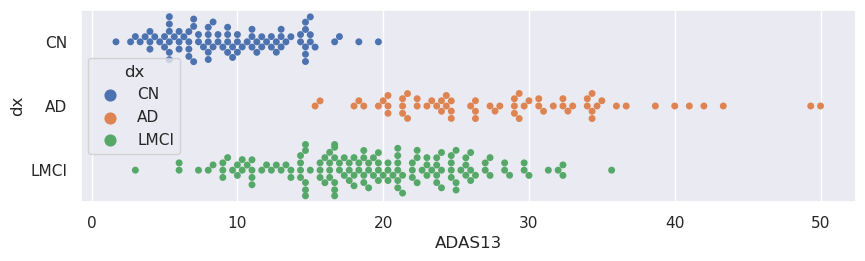

In [4]:
%%capture --no-display

# Plot using seaborn in a loop
sns.set_theme(style="whitegrid", palette="muted")

for i in feats:
    plt.figure()
    plt.tight_layout()
    sns.set(rc = {"figure.figsize": (10,2.5)})
    sns.swarmplot(data = adni_proc, x = i, y = 'dx', hue = 'dx')

## Step 4 - Statistical tests
After you have visually inspected the data, perform some statistical tests in order to assess whether there is evidence that these groups are significantly different from each other.  Remember there are three groups,with the most important comparison for ensuring that there is a disease-specific signal is CN vs AD (as MCI may be caused by AD or other etiologies.)

In [5]:
# Run stats

effectsizes = {}
stats_results = {}

for index, feat in enumerate(feats):
    cn = adni_proc.where(adni_proc.dx == 'CN').dropna()[feat]
    ad = adni_proc.where(adni_proc.dx == 'AD').dropna()[feat]
    effectsizes[feat] = np.absolute(np.median(ad)-np.median(cn))/stats.median_abs_deviation(cn)
    stats_results[feat] = stats.mannwhitneyu(cn,ad)

es_df = pd.DataFrame.from_dict(effectsizes, orient = 'Index')
es_df.rename(columns = {0: "Effect size"}, inplace = True)
stats_df = pd.DataFrame.from_dict(stats_results, orient = 'Index')
print(pd.concat([stats_df, es_df], axis = "columns"))


                 statistic        pvalue  Effect size
ABETA_INNO          1152.5  3.391984e-10     2.089744
log_ptau             900.5  5.368503e-13     2.599329
log_tau              944.5  1.788092e-12     3.087170
ventricles_norm     1652.0  8.790913e-06     1.341519
hippo_norm           702.0  1.864358e-15     3.984564
fusiform_norm       1673.0  1.250792e-05     1.365254
ec_norm              690.0  1.299169e-15     2.404388
mtc_norm            1097.0  8.895234e-11     2.077482
ANN_BBSI            1047.0  2.563543e-11     2.303063
ANN_HBSI             941.0  1.635597e-12     2.341889
MMSE                  31.5  4.053719e-26     5.000000
RAVLT_immediate      117.0  3.850702e-24     3.333333
ADAS13                13.5  7.122388e-26     5.846761


## Step 5 - Mixture model
In the walkthrough, we used the KDE approach to determine the probability distribution that an event has occurred. However, in the original implementation for the Young *et al.* paper, this was done using a parametric approach with Gaussian Mixture Models. This can be done using the 'fit_all_gmm_models' command instead of the 'fit_all_kde_models' command. Make sure to use the special coding of diagnosis as your labels for the EBM input.

One other difference that is critically important. In the walkthrough we simulated 100 "completely healthy" individuals as controls, i.e. they had no evidence of abnormality in any of the biomarkers. In the ADNI cohort this is not the case. We know that Alzheimer's disease pathology begins very early in the process, in some cases 20 years before signs of cognitive impairment are so pronounces that they would meet the criteria for a diagnosis of probable AD. As a result there are many controls in our group who actually have abnormal biomarkers. This is mentioned in the *Young et al.* paper:
> In sporadic Alzheimer’s disease, however, a significant proportion of the cognitively
> normal control group may have presymptomatic Alzheimer’s disease. To counter this,
> we fitted a mixture of two normal distributions to each biomarker separately using 
> data from all subjects to obtain the two models. To ensure a robust fit, 
> particularly for biomarkers where the distributions of the healthy and diseased 
> population overlap significantly, we constrain the standard deviations so that the 
> standard deviation of P(x|~E_i) and P(x|E_i) is less than or equal to that of the 
> cognitively normal and Alzheimer’s disease group, respectively.

The constraint mentioned above can be implemented in the `fit_all_gmm_models` by setting the function argument `fit_all_subjects` to `True`. This is why we needed to have our labels such that cognitively normals were 0 and AD were 1, so that the constraints would be applied to the correct groups. 

After the mixture models have been fitted for each feature, make sure to take a look at them and see if they make sense.

(<Figure size 1200x1200 with 13 Axes>,
 array([[<AxesSubplot:title={'center':'ABETA_INNO'}>,
         <AxesSubplot:title={'center':'log_ptau'}>,
         <AxesSubplot:title={'center':'log_tau'}>,
         <AxesSubplot:title={'center':'ventricles_norm'}>],
        [<AxesSubplot:title={'center':'hippo_norm'}>,
         <AxesSubplot:title={'center':'fusiform_norm'}>,
         <AxesSubplot:title={'center':'ec_norm'}>,
         <AxesSubplot:title={'center':'mtc_norm'}>],
        [<AxesSubplot:title={'center':'ANN_BBSI'}>,
         <AxesSubplot:title={'center':'ANN_HBSI'}>,
         <AxesSubplot:title={'center':'MMSE'}>,
         <AxesSubplot:title={'center':'RAVLT_immediate'}>],
        [<AxesSubplot:title={'center':'ADAS13'}>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

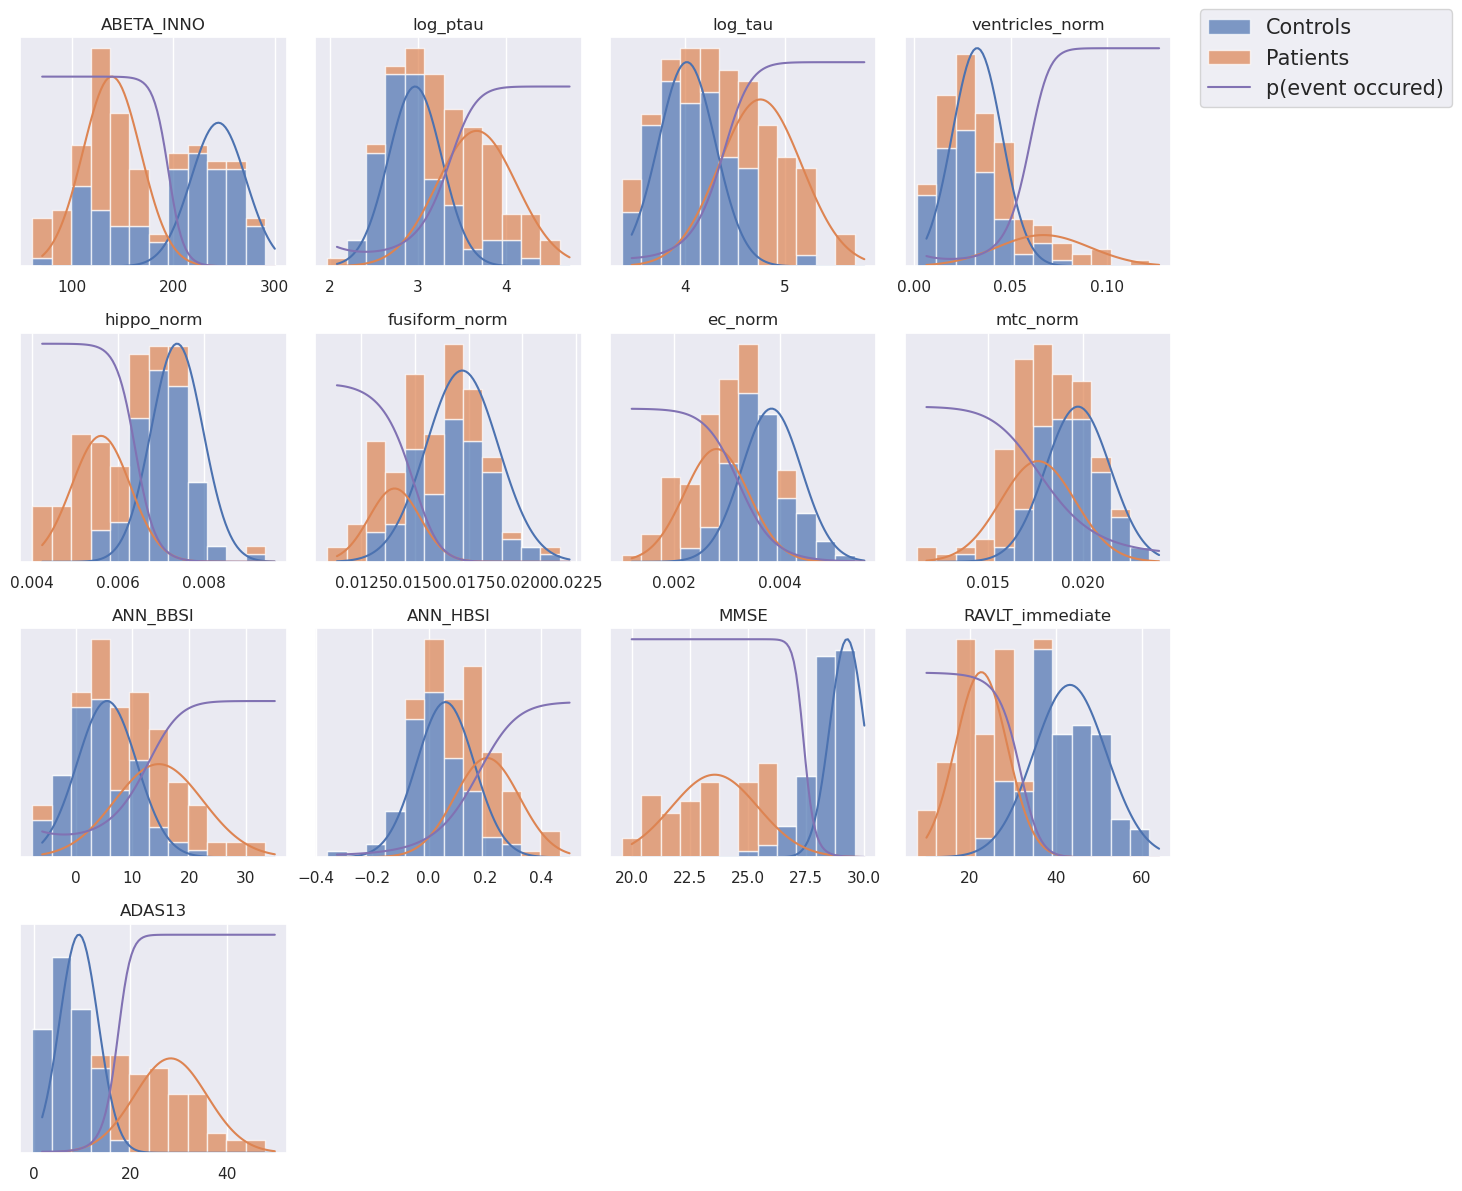

In [6]:
# Generate Gaussian Mixture Models

ebm_data = adni_proc.where(adni_proc.dx != 'LMCI').dropna()

# Convert to numpy arrays because otherwise it throws an error.
biomarkers = ebm_data[feats].to_numpy()
dx_labels = ebm_data['dx_num'].to_numpy().astype('int')

gmm_mixtures = fit_all_gmm_models(
    biomarkers, dx_labels,
    fit_all_subjects = True)

#* View the mixture models
mixture_model_grid(
    biomarkers,dx_labels,
    gmm_mixtures,
    score_names=feats,
    class_names=['Controls','Patients']
)

## Step 6 - Running the EBM
Now that you have the mixture models, it is time to run the EBM. In the code cell(s) below, please run your MCMC sampling.

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4731.48it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4648.32it/s]


ML order   : ANN_BBSI, ABETA_INNO, log_ptau, log_tau, MMSE, ADAS13, RAVLT_immediate, ec_norm, hippo_norm, ANN_HBSI, mtc_norm, ventricles_norm, fusiform_norm


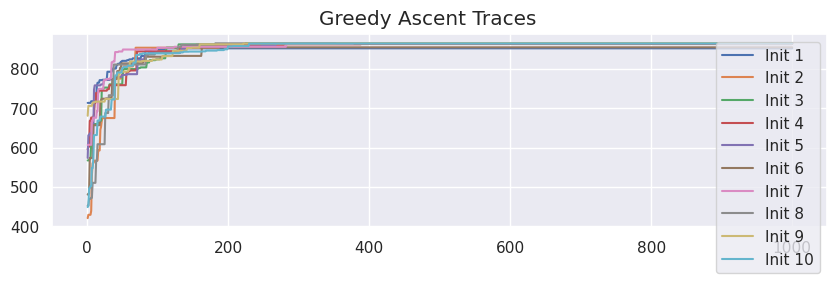

In [7]:
# Set empty dict
ebm_results = {}

# Set up samples
gmm_mcmc_samples = mcmc(biomarkers, gmm_mixtures)

# Obtain the maximum Likelihood sequence over all samples
gmm_seq_ml = gmm_mcmc_samples[0].ordering

#print(gmm_seq_ml)
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([feats[k] for k in gmm_seq_ml]))
ebm_results['GMM'] = {"mixtures": gmm_mixtures, "mcmc_samples": gmm_mcmc_samples, "sequence_ml": gmm_seq_ml}

## Plot uncertainty

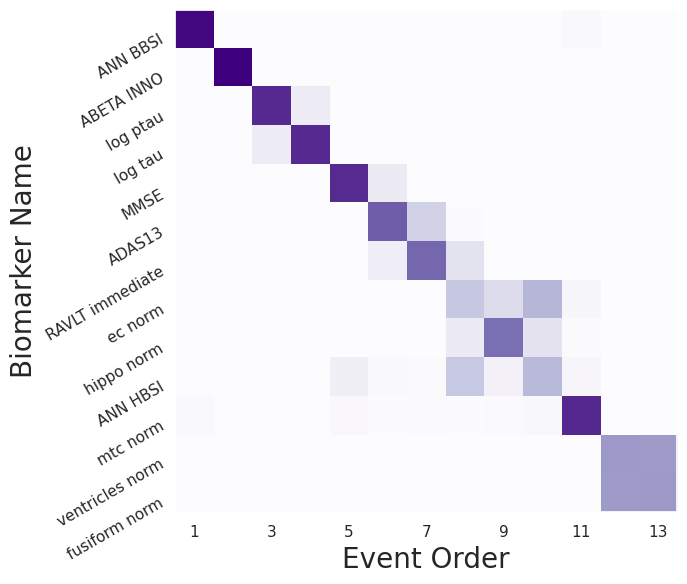

In [8]:
f,a = mcmc_uncert_mat(gmm_mcmc_samples, ml_order=None, score_names=feats)

## Step 7 - Positional Variance Diagram
Perform the necessary steps to get the positional variance diagram. Which features are we confident of their position and which ones are we not? Does your positional variance diagram coincide with the paper? In what ways are they different? What are the best practices for producing a PVD.

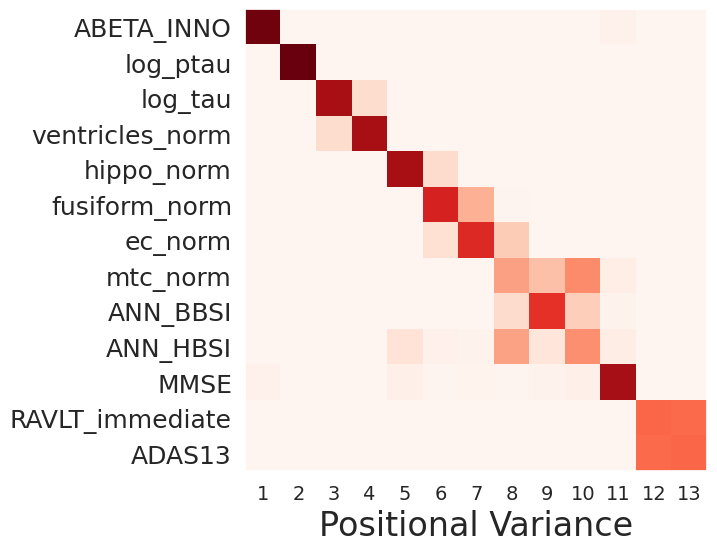

In [9]:
# Plot PVD

import kde_utils 

pvd_ml, seq_ml = kde_utils.extract_pvd(ml_order=gmm_seq_ml,samples=gmm_mcmc_samples)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = feats
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
#labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Positional Variance', fontsize=24)
ax.grid(False)

#kde_utils.save_plot(fig, nom+"-PVD_ML")


## Step 8 - Staging
Validate this data by looking at the stages of each individual. What stages are the controls in? What does the staging of the MCI look like compared to the dementia.

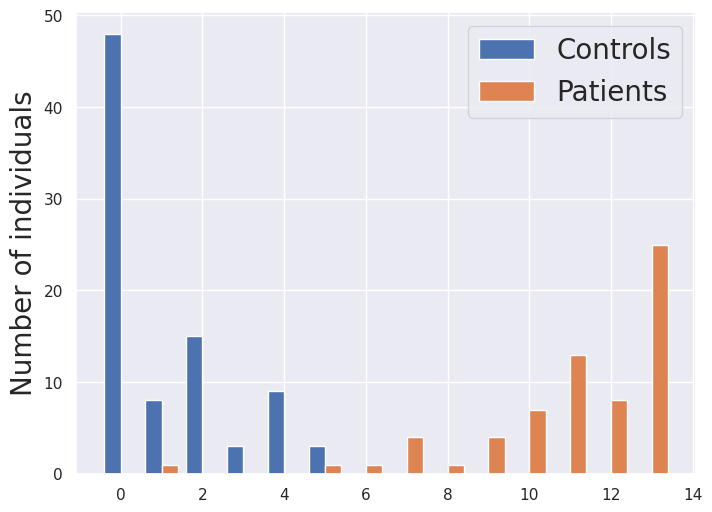

In [10]:
# Patient staging using Maximum Likelihood
gmm_prob_mat_ml, gmm_stages_long_ml, gmm_stage_likelihoods_long_ml, gmm_stages_long_ml_expected = kde_utils.ebm_staging(
    x=biomarkers,
    mixtures=gmm_mixtures,
    samples=gmm_mcmc_samples
)
gmm_stages_long = gmm_stages_long_ml

fig, ax = plt.subplots(figsize=(8,6))

ax.hist([ gmm_stages_long[dx_labels==0], gmm_stages_long[dx_labels==1]],bins=np.arange(-0.5,len(feats)+1.5,1))
ax.set_ylabel('Number of individuals',fontsize=20)
ax.legend(['Controls','Patients'],fontsize=20)

## Step 9 - Explore
**Congratulations** you have succeeded in the Team Coders task! Now the goal is to take what you have learned and think about what questions you would like to answer with the EBM. What other analyses were done in the paper? What things could we change?
Here are some potential things you may want to try:
* Using the KDE method of mixture modelling, how does the ordering change. Looking at what we have stated in Step 5, why might these orderings be different
* Look at specific populations, say individuals who have the risk gene *APOE* $\epsilon4$ ?
* Try more principled methods of uncertainty using cross-fold validation.

# Run GMMs using CV

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5058.33it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4909.28it/s]


Repeated CV fold 1 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4996.97it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4892.70it/s]


Repeated CV fold 2 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5023.97it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4820.61it/s]


Repeated CV fold 3 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4803.29it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4712.10it/s]


Repeated CV fold 4 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4926.96it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4816.38it/s]


Repeated CV fold 5 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5024.73it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4849.87it/s]


Repeated CV fold 6 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4973.64it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4834.64it/s]


Repeated CV fold 7 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4900.78it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4813.13it/s]


Repeated CV fold 8 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4896.43it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4818.62it/s]


Repeated CV fold 9 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4878.98it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4809.57it/s]


Repeated CV fold 10 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4941.39it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4764.42it/s]


Repeated CV fold 11 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4940.23it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4802.49it/s]


Repeated CV fold 12 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4894.68it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4832.57it/s]


Repeated CV fold 13 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4901.65it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4778.00it/s]


Repeated CV fold 14 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4889.01it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4801.40it/s]


Repeated CV fold 15 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4960.46it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4836.96it/s]


Repeated CV fold 16 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4922.94it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4834.55it/s]


Repeated CV fold 17 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4917.65it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4816.08it/s]


Repeated CV fold 18 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4922.53it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4821.45it/s]


Repeated CV fold 19 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5014.98it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4837.00it/s]


Repeated CV fold 20 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4958.63it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/plotting/plotting.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4860.54it/s]


Repeated CV fold 21 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4916.05it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4830.84it/s]


Repeated CV fold 22 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4925.37it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4836.66it/s]


Repeated CV fold 23 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4935.45it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4869.00it/s]


Repeated CV fold 24 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4969.54it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4853.50it/s]


Repeated CV fold 25 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4956.68it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4875.19it/s]


Repeated CV fold 26 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4953.15it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4848.90it/s]


Repeated CV fold 27 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4985.57it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4845.59it/s]


Repeated CV fold 28 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4953.67it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4858.43it/s]


Repeated CV fold 29 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4953.58it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4819.70it/s]


Repeated CV fold 30 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4936.84it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4835.28it/s]


Repeated CV fold 31 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4906.71it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4829.50it/s]


Repeated CV fold 32 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4966.27it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4827.49it/s]


Repeated CV fold 33 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4920.77it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4795.59it/s]


Repeated CV fold 34 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4923.96it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4810.17it/s]


Repeated CV fold 35 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4981.24it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4848.98it/s]


Repeated CV fold 36 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4972.71it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4835.41it/s]


Repeated CV fold 37 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4951.15it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4803.06it/s]


Repeated CV fold 38 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4933.58it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4844.60it/s]


Repeated CV fold 39 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4979.52it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4846.41it/s]


Repeated CV fold 40 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5001.33it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4865.89it/s]


Repeated CV fold 41 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4924.09it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4813.95it/s]


Repeated CV fold 42 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4992.41it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4865.73it/s]


Repeated CV fold 43 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4959.36it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4841.85it/s]


Repeated CV fold 44 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4933.61it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4830.71it/s]


Repeated CV fold 45 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4964.27it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4853.24it/s]


Repeated CV fold 46 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4992.00it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4836.31it/s]


Repeated CV fold 47 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4967.17it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4853.87it/s]


Repeated CV fold 48 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4940.32it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4839.99it/s]


Repeated CV fold 49 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4996.15it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4830.50it/s]


Repeated CV fold 50 of 50


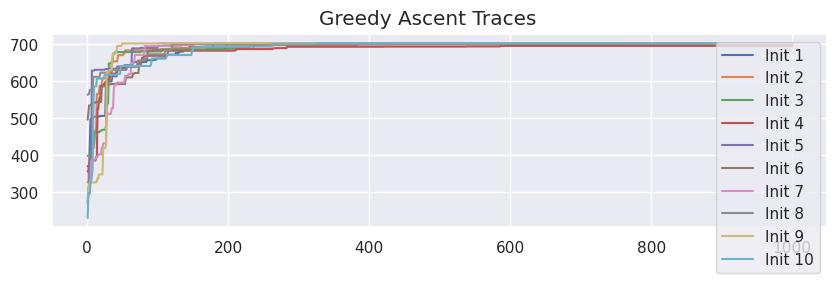

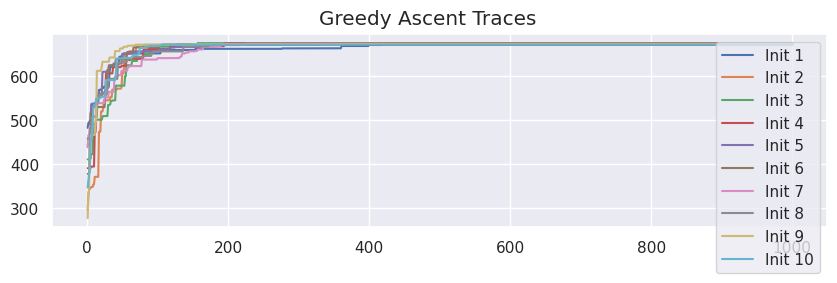

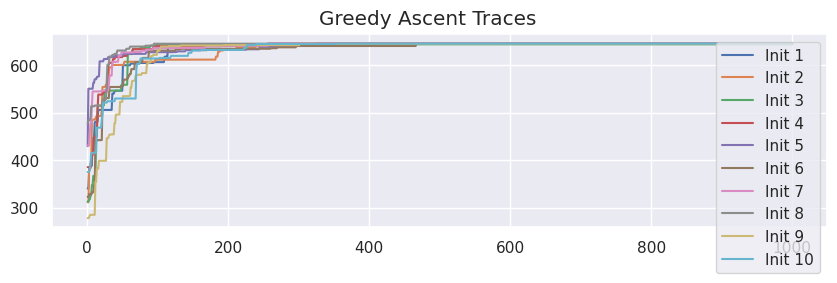

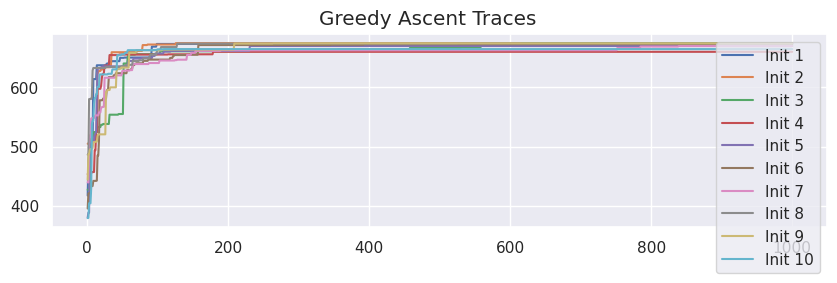

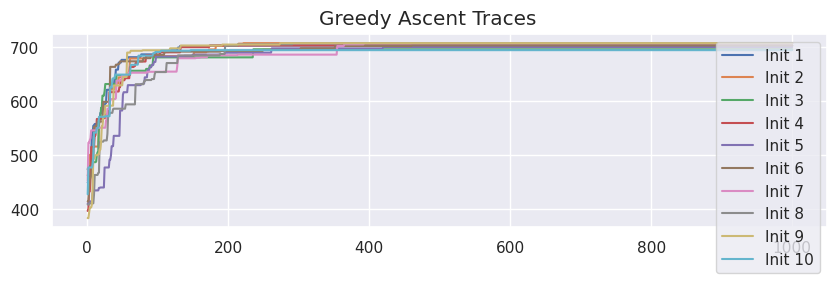

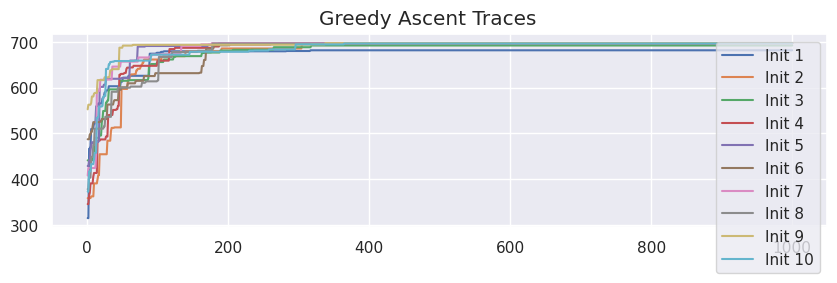

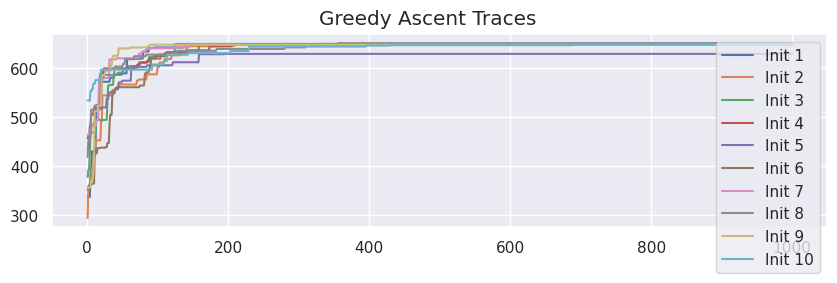

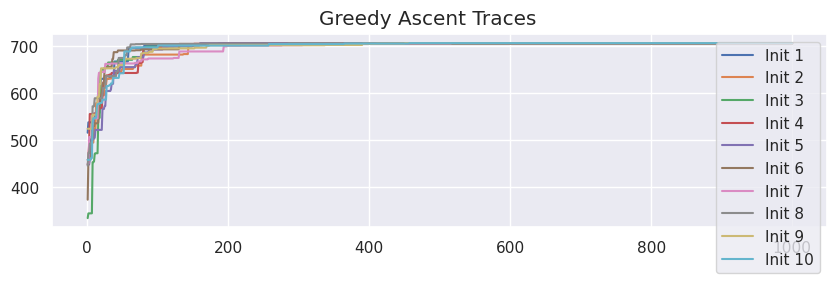

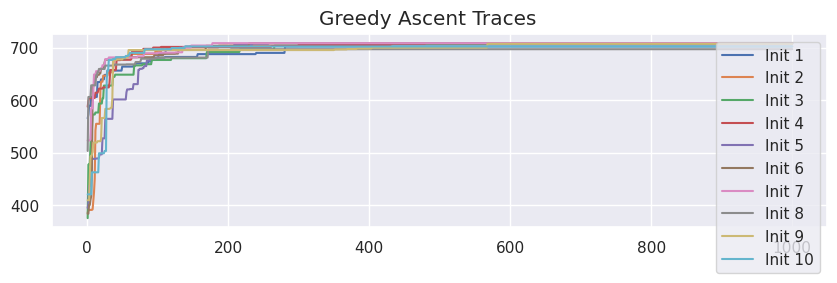

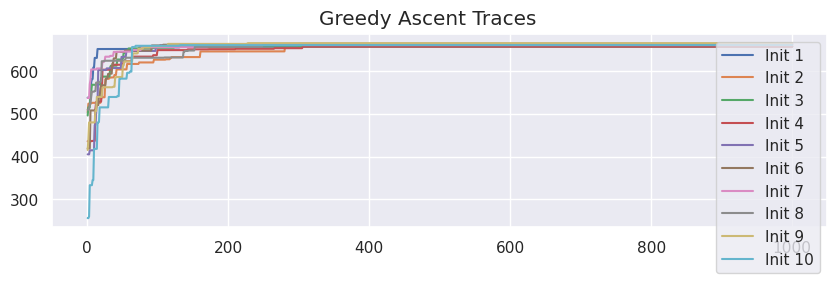

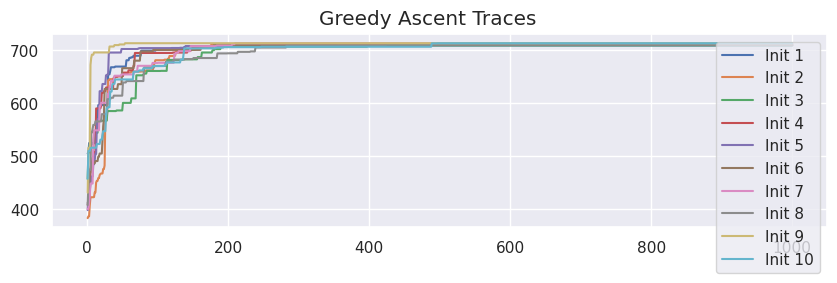

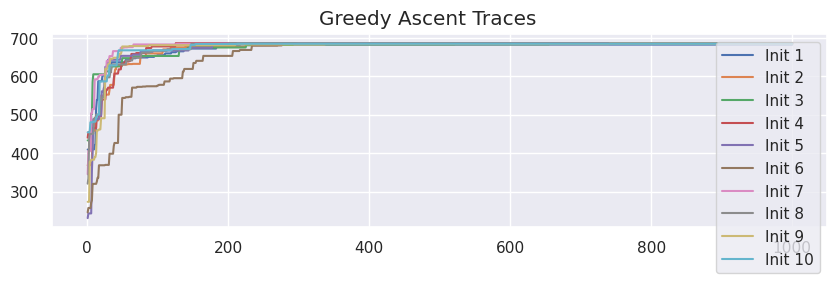

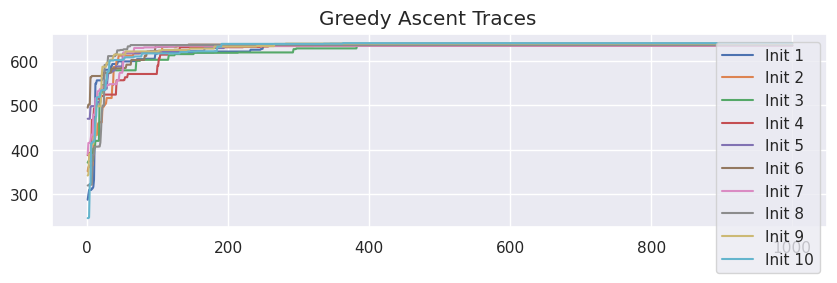

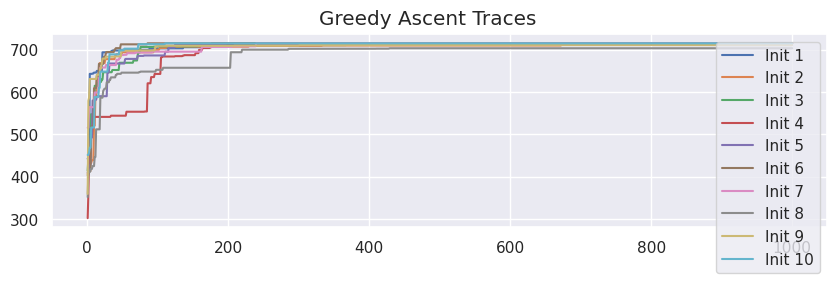

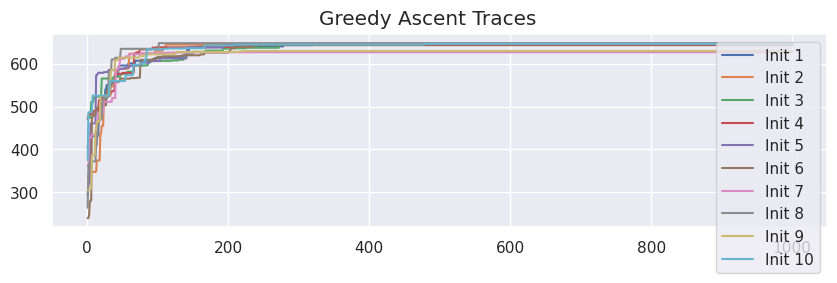

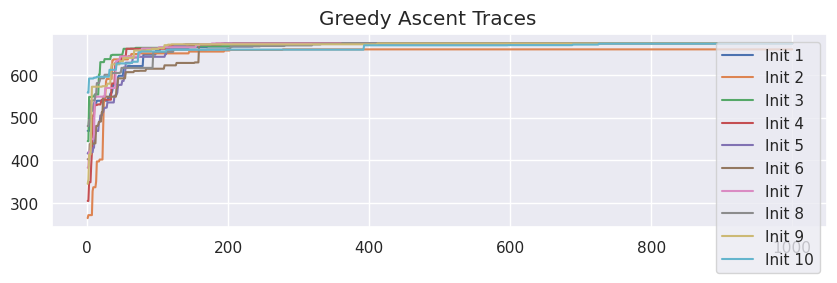

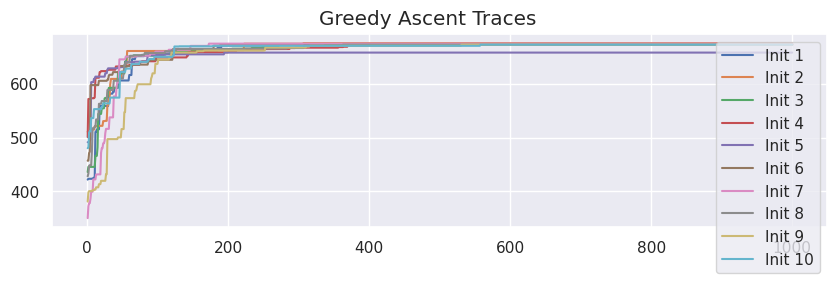

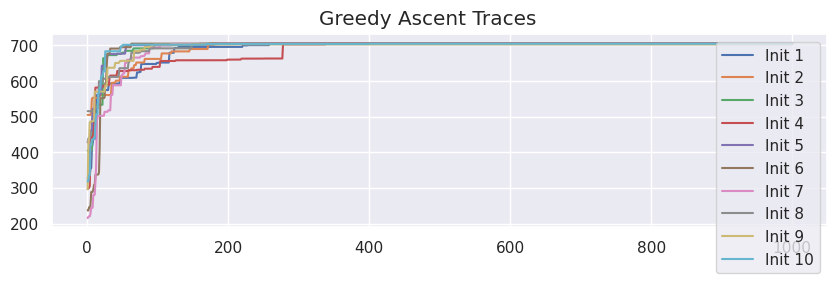

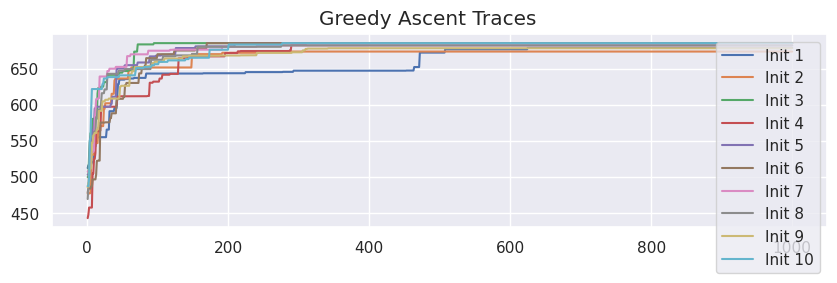

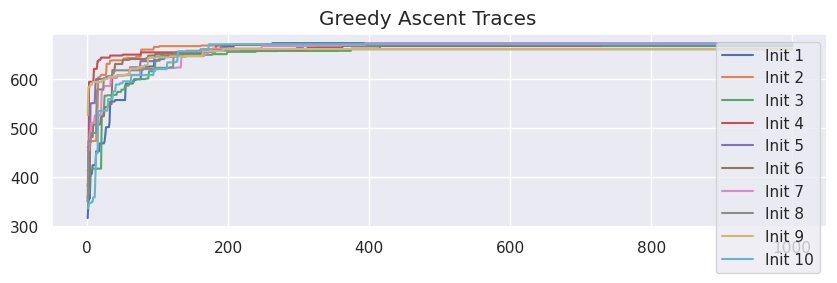

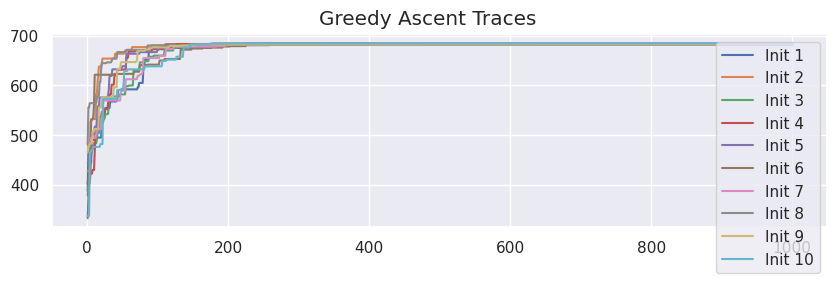

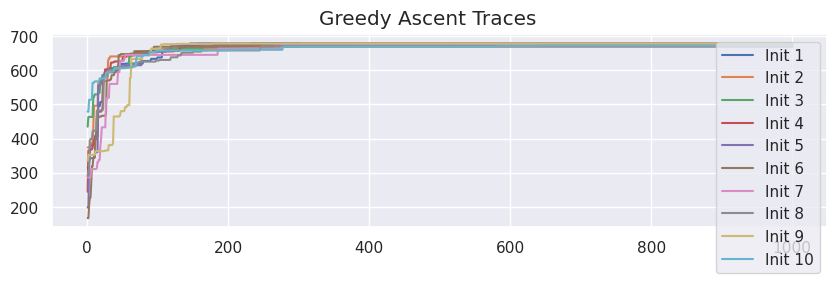

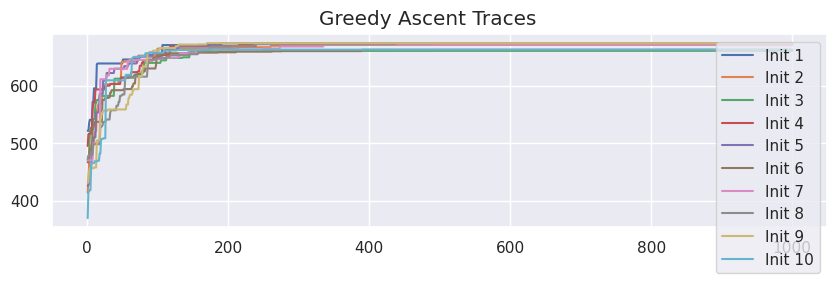

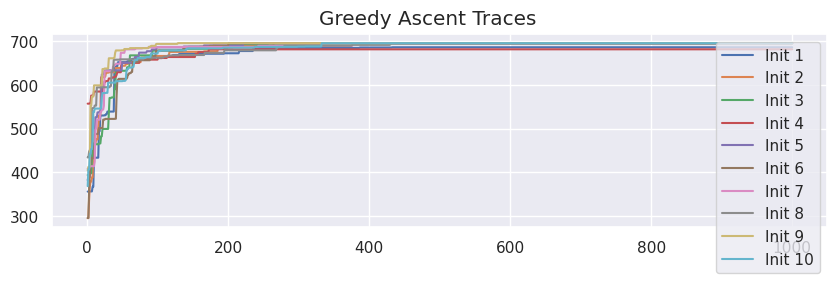

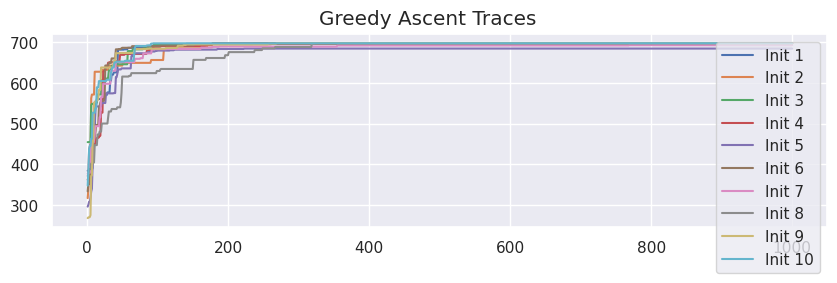

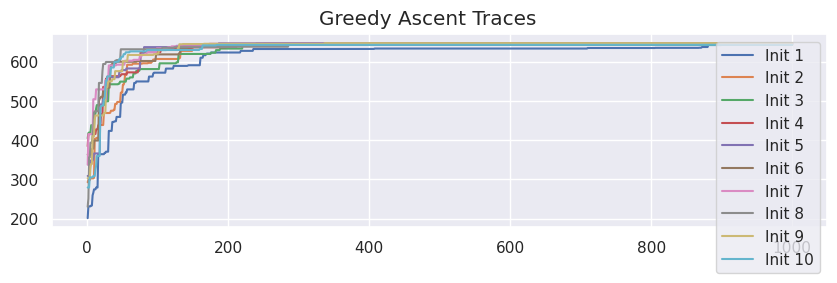

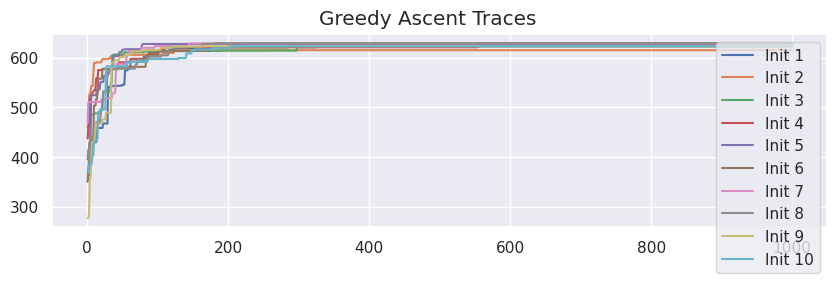

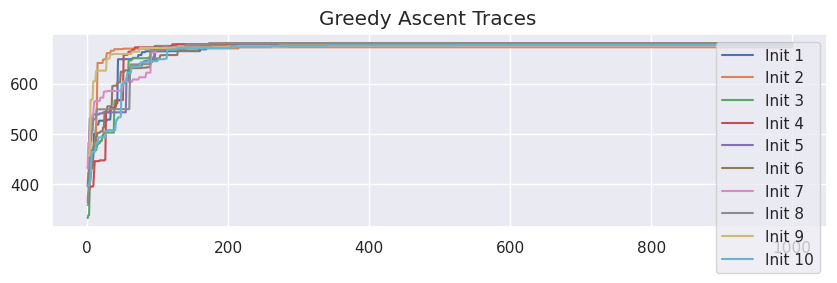

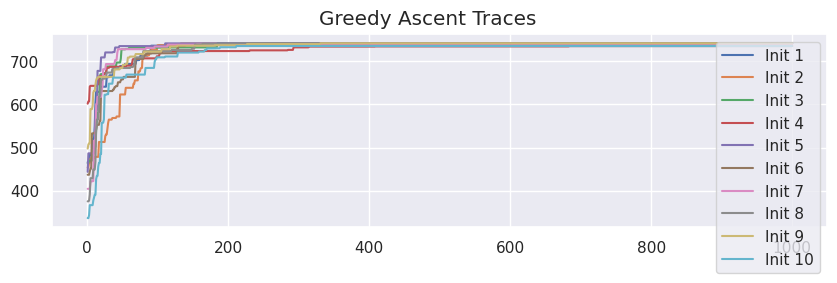

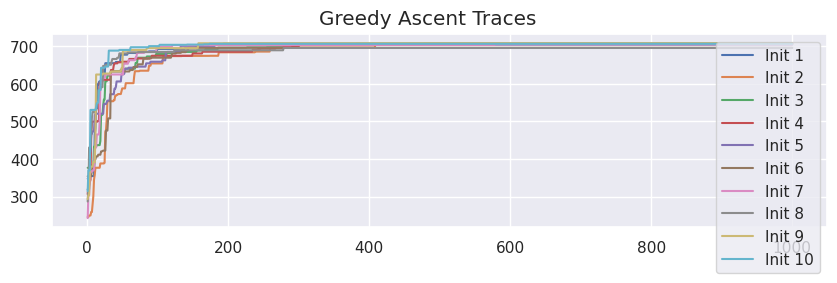

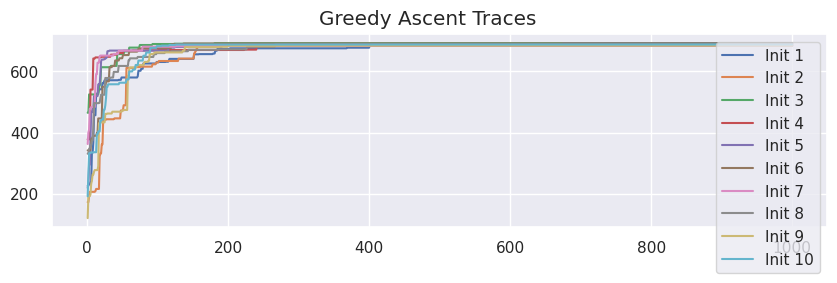

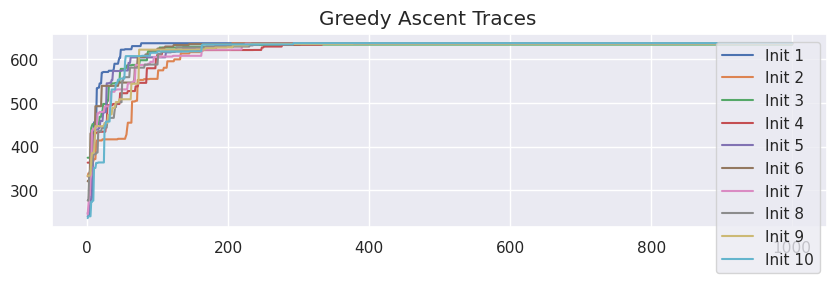

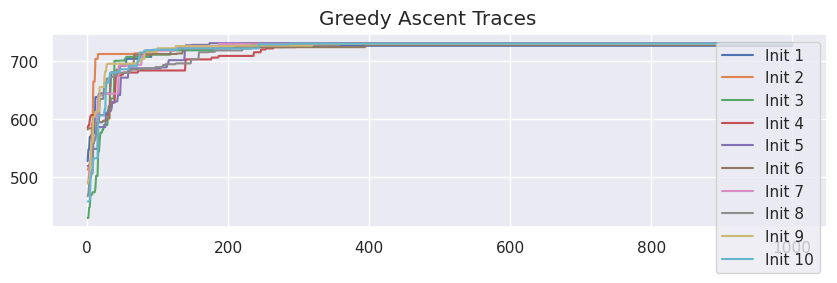

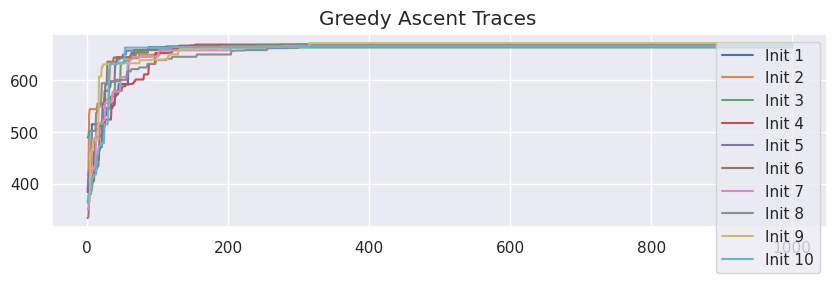

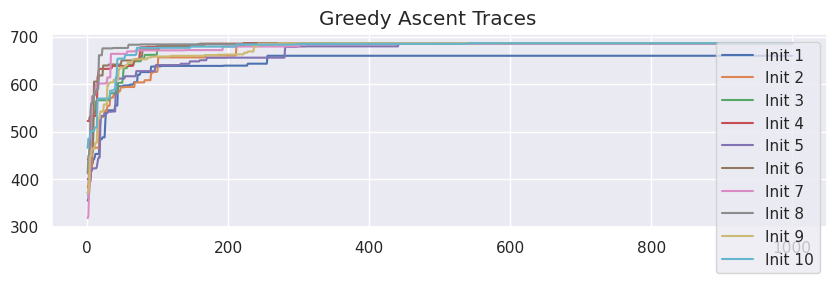

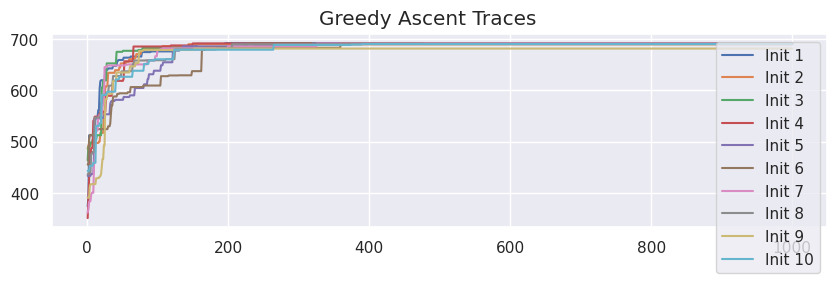

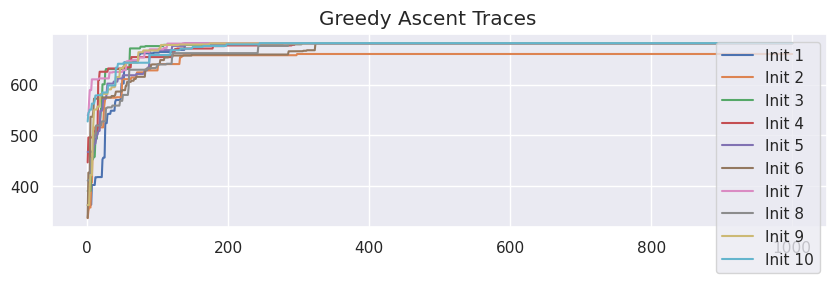

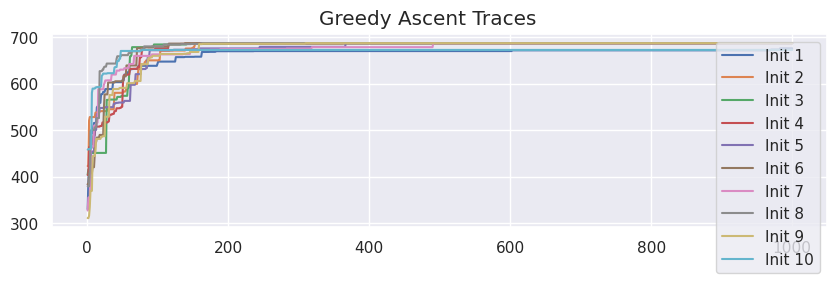

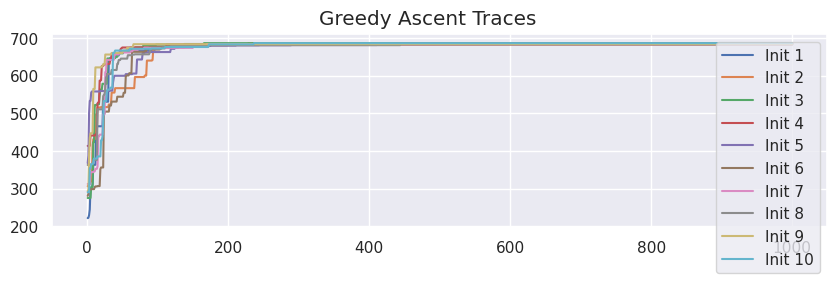

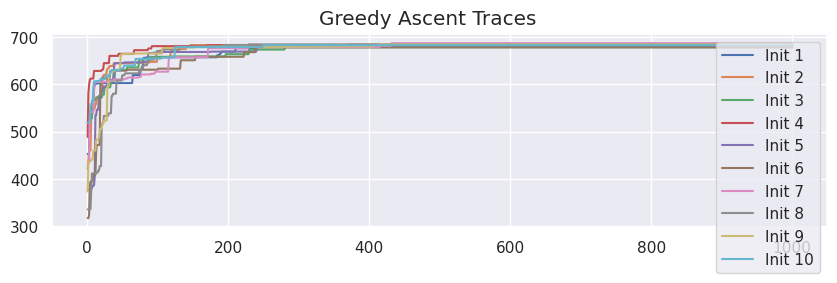

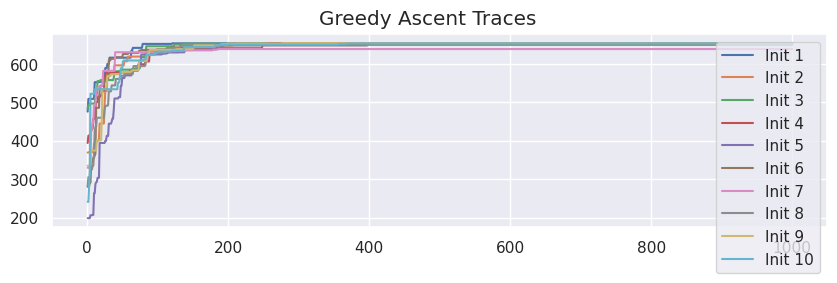

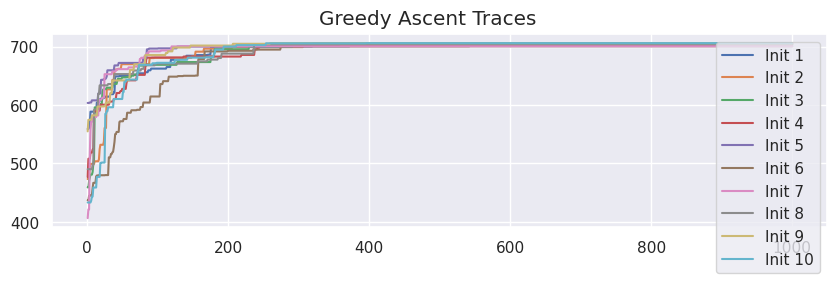

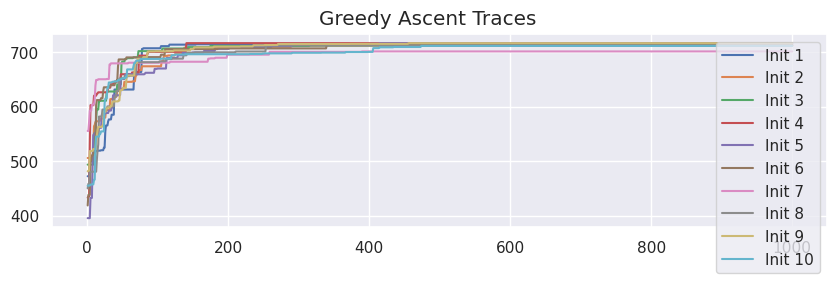

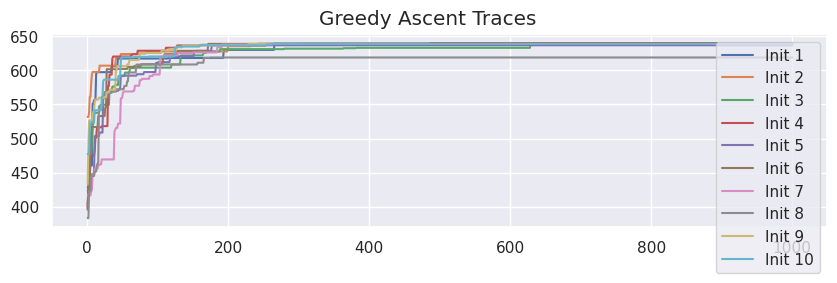

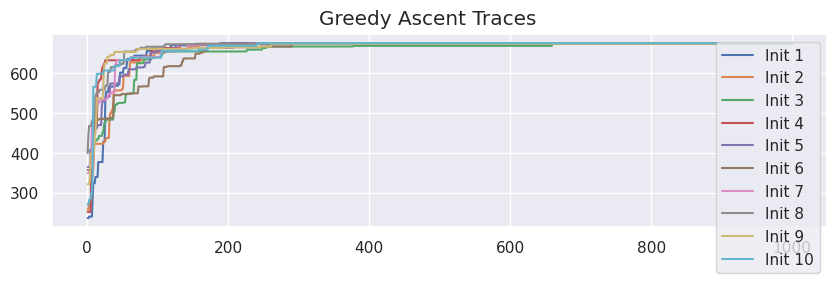

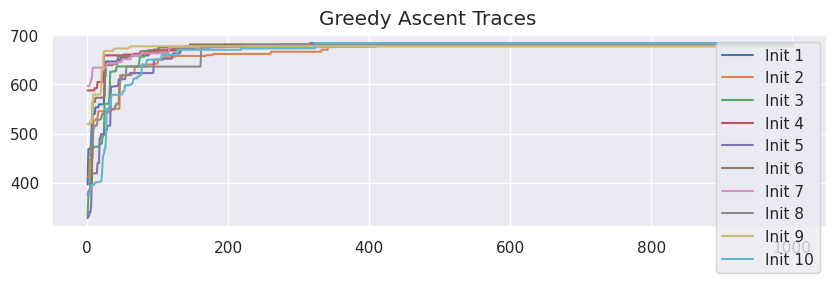

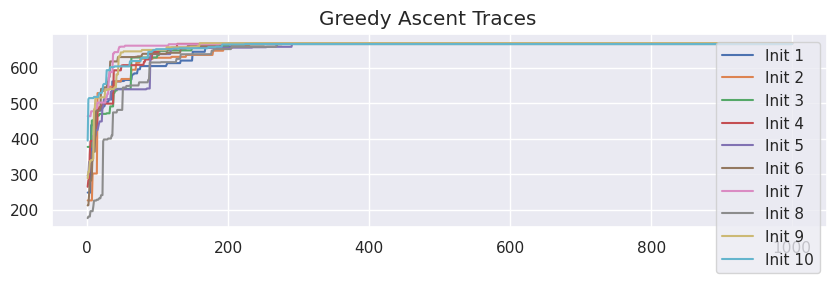

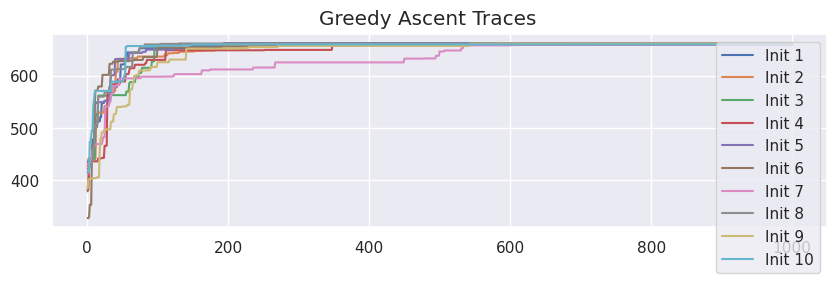

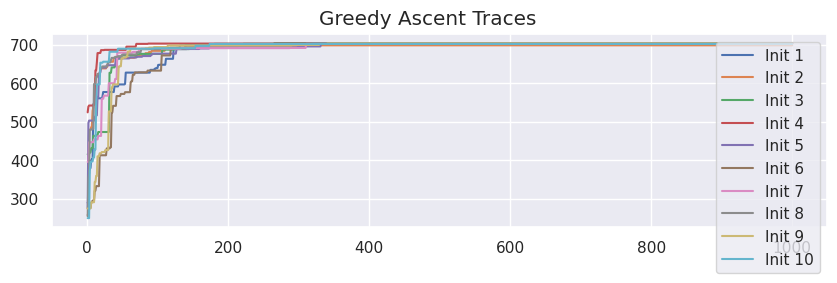

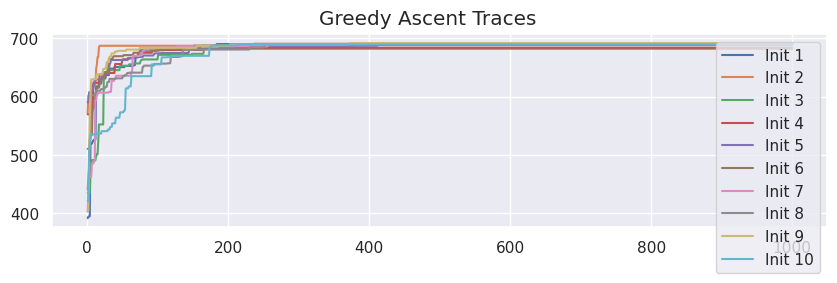

In [11]:
# CV 
from sklearn.model_selection import RepeatedStratifiedKFold

#* RCV1: Repeated, stratified 5-fold CV - uses ML stage as ground truth for test folds
k_folds = 5
n_repeats = 10

#Sets up the random folds to be used in cross-validation. This just states which folds
#each individual belongs to.
repeated_cvfolds = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats) #, random_state=36851234)

# Have we already run the EBM?
if 'ebm_results' in locals():
    check = True
else:
    check = False

#And if we have, have we already run the cross-validation? We can save some time
#if we already have. Otherwise, we will need to run it.
if check:
    if "gmm_mixtures_rcv" in ebm_results:
        gmm_mixtures_rcv = ebm_results["gmm_mixtures_rcv"]
        gmm_mcmc_samples_rcv = ebm_results["gmm_mcmc_samples_rcv"]
        gmm_seqs_rcv = ebm_results["gmm_sequences_rcv"]
        gmm_staging_errors_rcv = ebm_results["gmm_staging_errors_rcv"]
        runit = False
    else:
        runit = True
else:
    runit = True

if runit:
    gmm_mixtures_rcv, gmm_mcmc_samples_rcv, gmm_seqs_rcv, gmm_staging_errors_rcv = kde_utils.ebm_2_repeatedcv(
        x=biomarkers,
        y=dx_labels,
        events=feats,
        rcv_folds=repeated_cvfolds,
        model_stage=gmm_stages_long,
        kde_flag = False
    )
    #* Save
    ebm_results["gmm_mixtures_rcv"] = gmm_mixtures_rcv
    ebm_results["gmm_mcmc_samples_rcv"] = gmm_mcmc_samples_rcv
    ebm_results["gmm_seqs_rcv"] = gmm_seqs_rcv
    ebm_results["gmm_staging_errors_rcv"] = gmm_staging_errors_rcv
    # pickle_file = open(pickle_path,'wb')
    # pickle_output = pickle.dump(ebm_results, pickle_file)
    # pickle_file.close()

## Position Variance Diagram of GMMs based on CV

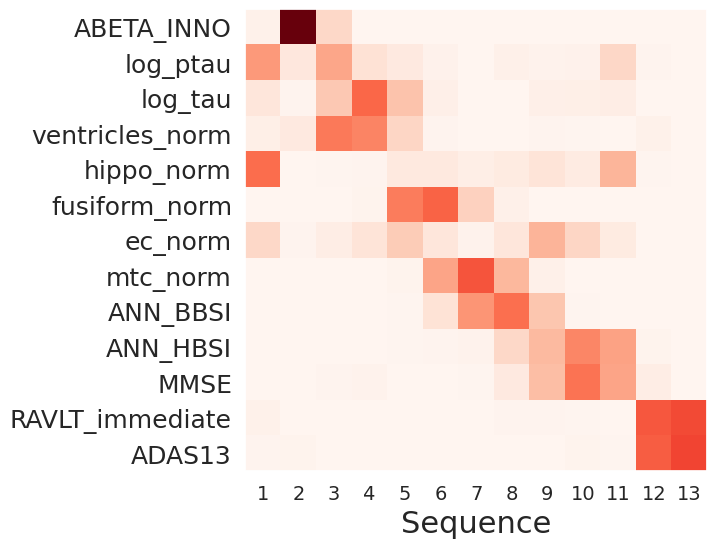

In [12]:
#* Plot EBM (PVD)
pvd_rcv, seq_rcv = kde_utils.extract_pvd(ml_order=gmm_seqs_rcv,samples=gmm_mcmc_samples_rcv)
reorder_rcv = np.argsort(seq_rcv)
pvd_rcv_ = pvd_rcv[:][reorder_rcv]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = feats
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_rcv]
ax.imshow(pvd_rcv_[:][seq_rcv], interpolation='nearest', cmap='Reds')
# ax.set_title('Cross-Validation',fontsize=24)

n_biomarkers = pvd_rcv.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0)
ax.tick_params(axis='y',color='w')
#labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Sequence', fontsize=22)
ax.grid(False)

# Run KDE Model

(<Figure size 1200x1200 with 13 Axes>,
 array([[<AxesSubplot:title={'center':'ABETA_INNO'}>,
         <AxesSubplot:title={'center':'log_ptau'}>,
         <AxesSubplot:title={'center':'log_tau'}>,
         <AxesSubplot:title={'center':'ventricles_norm'}>],
        [<AxesSubplot:title={'center':'hippo_norm'}>,
         <AxesSubplot:title={'center':'fusiform_norm'}>,
         <AxesSubplot:title={'center':'ec_norm'}>,
         <AxesSubplot:title={'center':'mtc_norm'}>],
        [<AxesSubplot:title={'center':'ANN_BBSI'}>,
         <AxesSubplot:title={'center':'ANN_HBSI'}>,
         <AxesSubplot:title={'center':'MMSE'}>,
         <AxesSubplot:title={'center':'RAVLT_immediate'}>],
        [<AxesSubplot:title={'center':'ADAS13'}>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

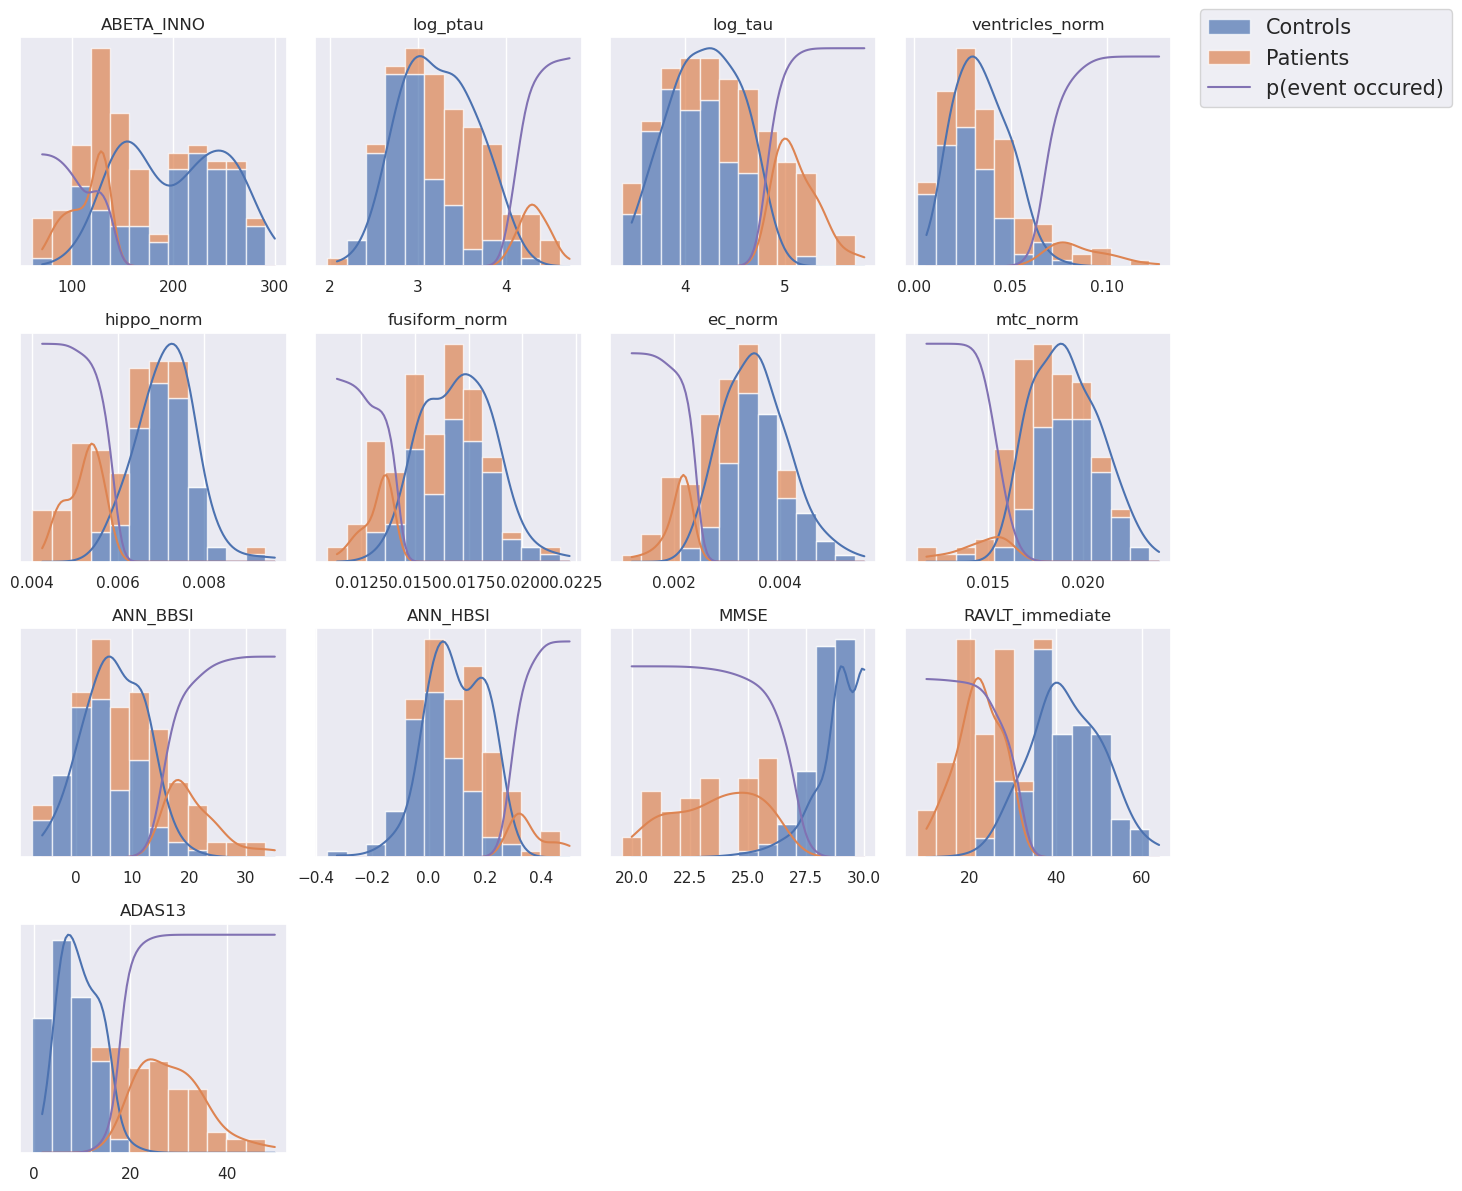

In [13]:
# Define disease direction for biomarkers
event_disease_dict = {
    'ABETA_INNO': -1,
    'log_ptau': 1,
    'log_tau': 1,
    'ventricles_norm': 1, 
    'hippo_norm': -1, 
    'fusiform_norm': -1, 
    'ec_norm': -1, 
    'mtc_norm': -1,
    'ANN_BBSI': 1, 
    'ANN_HBSI': 1,
    'MMSE': -1, 
    'RAVLT_immediate': -1, 
    'ADAS13': 1
}

event_disease_direction = [event_disease_dict[f] for f in feats]

kde_mixtures = fit_all_kde_models(
    biomarkers, 
    dx_labels,    
    implement_fixed_controls = True,
    patholog_dirn_array      = event_disease_direction)

#* View the mixture models
mixture_model_grid(
    biomarkers, dx_labels,
    kde_mixtures,
    score_names=feats,
    class_names=['Controls','Patients']
)

## KDE MCMC

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4741.34it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4650.11it/s]


ML order   : MMSE, ADAS13, RAVLT_immediate, log_tau, ANN_BBSI, hippo_norm, ABETA_INNO, ec_norm, fusiform_norm, ventricles_norm, mtc_norm, ANN_HBSI, log_ptau


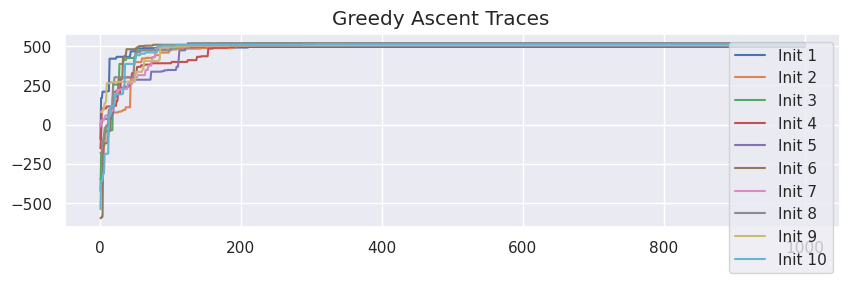

In [14]:
#* Perform MCMC sequencing and store results in mcmc_samples
kde_mcmc_samples = mcmc(biomarkers, kde_mixtures)
#* Obtaine the maximum Likelihood sequence over all samples
kde_seq_ml = kde_mcmc_samples[0].ordering
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([feats[k] for k in kde_seq_ml]))

## KDE Positional Variance Diagram

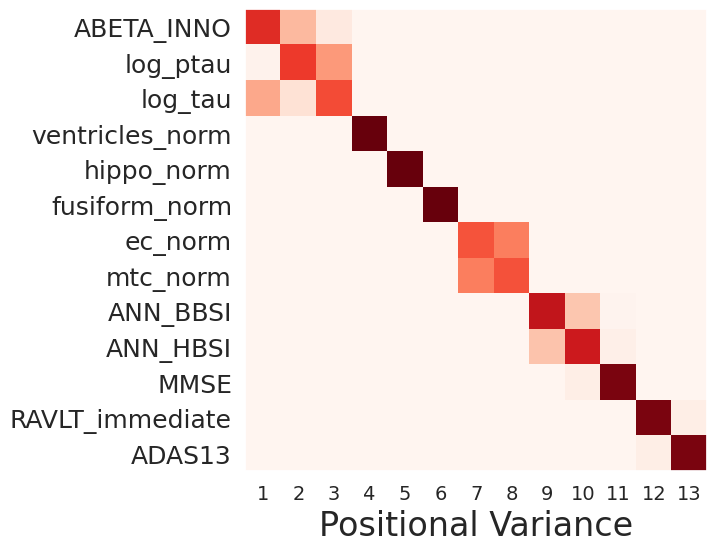

In [15]:
# Plot PVD
pvd_ml, seq_ml = kde_utils.extract_pvd(ml_order=kde_seq_ml,samples=kde_mcmc_samples)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = feats
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
ax.set_yticklabels(labels,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Positional Variance', fontsize=24)
ax.grid(False)

#kde_utils.save_plot(fig, nom+"-PVD_ML")


## KDE Staging

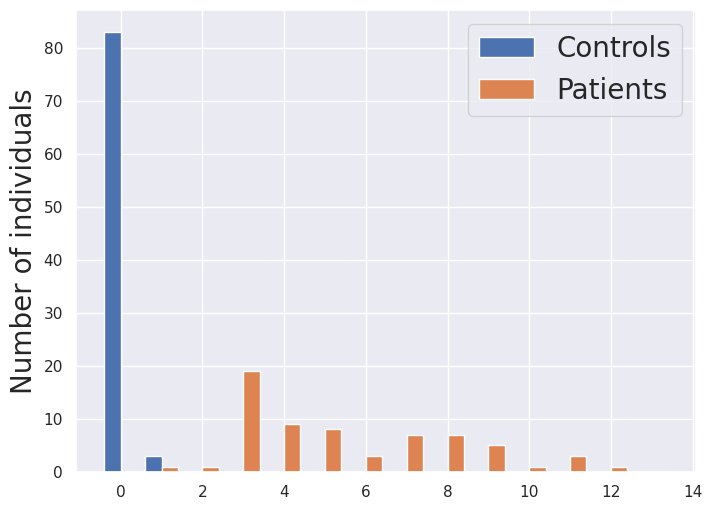

In [16]:
# Patient staging using Maximum Likelihood
kde_prob_mat_ml, kde_stages_long_ml, kde_stage_likelihoods_long_ml, kde_stages_long_ml_expected = kde_utils.ebm_staging(
    x=biomarkers,
    mixtures=kde_mixtures,
    samples=kde_mcmc_samples
)
kde_stages_long = kde_stages_long_ml

fig, ax = plt.subplots(figsize=(8,6))

ax.hist([ kde_stages_long[dx_labels==0], kde_stages_long[dx_labels==1]],bins=np.arange(-0.5,len(feats)+1.5,1))
ax.set_ylabel('Number of individuals',fontsize=20)
ax.legend(['Controls','Patients'],fontsize=20)

## KDE Cross-validation

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5032.57it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4937.77it/s]


Repeated CV fold 1 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5020.96it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4906.44it/s]


Repeated CV fold 2 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5032.07it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4880.47it/s]


Repeated CV fold 3 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5001.58it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4869.22it/s]


Repeated CV fold 4 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5026.04it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4882.30it/s]


Repeated CV fold 5 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5038.43it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4859.26it/s]


Repeated CV fold 6 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4928.76it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4791.34it/s]


Repeated CV fold 7 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4920.01it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4820.86it/s]


Repeated CV fold 8 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4877.90it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4827.98it/s]


Repeated CV fold 9 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4984.42it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4852.14it/s]


Repeated CV fold 10 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5010.28it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4868.78it/s]


Repeated CV fold 11 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4934.90it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4849.56it/s]


Repeated CV fold 12 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5019.87it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4889.98it/s]


Repeated CV fold 13 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4986.29it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4868.51it/s]


Repeated CV fold 14 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4964.03it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4898.36it/s]


Repeated CV fold 15 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5021.48it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4894.81it/s]


Repeated CV fold 16 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5002.18it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4857.69it/s]


Repeated CV fold 17 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4966.38it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4876.43it/s]


Repeated CV fold 18 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4989.48it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4877.15it/s]


Repeated CV fold 19 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5039.95it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4886.42it/s]


Repeated CV fold 20 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5042.76it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/plotting/plotting.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4948.95it/s]


Repeated CV fold 21 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4996.29it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4866.98it/s]


Repeated CV fold 22 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5017.31it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4896.96it/s]


Repeated CV fold 23 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5035.62it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4877.97it/s]


Repeated CV fold 24 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4970.79it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4884.78it/s]


Repeated CV fold 25 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5044.25it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4608.67it/s]


Repeated CV fold 26 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5033.56it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4876.64it/s]


Repeated CV fold 27 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5048.66it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4876.90it/s]


Repeated CV fold 28 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5030.75it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4887.94it/s]


Repeated CV fold 29 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5038.65it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4894.09it/s]


Repeated CV fold 30 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5019.78it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4858.03it/s]


Repeated CV fold 31 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5060.91it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4904.89it/s]


Repeated CV fold 32 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5045.72it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4873.48it/s]


Repeated CV fold 33 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5036.12it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4908.94it/s]


Repeated CV fold 34 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5033.67it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4926.86it/s]


Repeated CV fold 35 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5036.38it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4932.54it/s]


Repeated CV fold 36 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5034.05it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4909.92it/s]


Repeated CV fold 37 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5042.02it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4825.84it/s]


Repeated CV fold 38 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5098.04it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4932.24it/s]


Repeated CV fold 39 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4997.15it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4918.79it/s]


Repeated CV fold 40 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5077.65it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4914.62it/s]


Repeated CV fold 41 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5047.33it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4897.54it/s]


Repeated CV fold 42 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5045.03it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4904.86it/s]


Repeated CV fold 43 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5029.50it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4915.12it/s]


Repeated CV fold 44 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5052.44it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4900.21it/s]


Repeated CV fold 45 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5060.71it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4947.22it/s]


Repeated CV fold 46 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5023.49it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4881.36it/s]


Repeated CV fold 47 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5037.27it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4914.70it/s]


Repeated CV fold 48 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5063.74it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4905.63it/s]


Repeated CV fold 49 of 50


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5046.40it/s]
/home/u26/adamraikes/.conda/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4911.18it/s]


Repeated CV fold 50 of 50


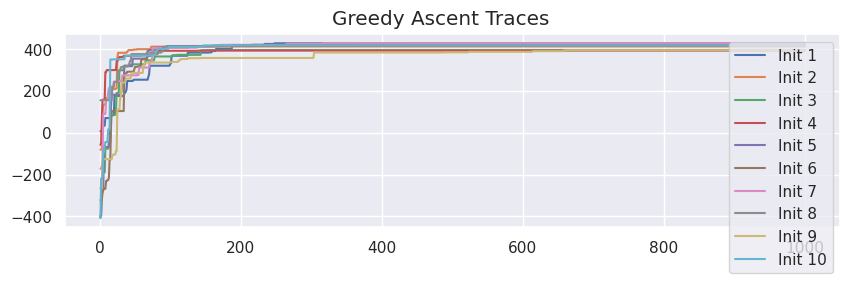

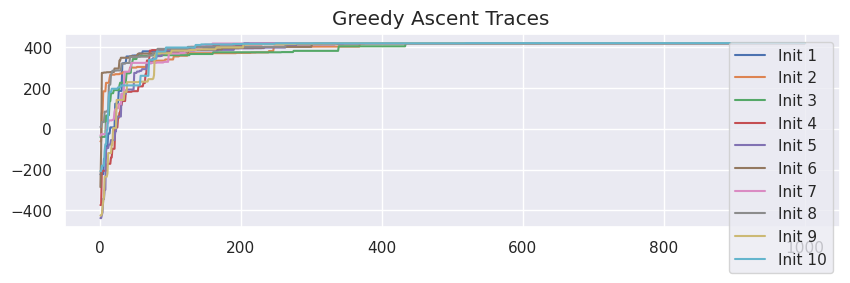

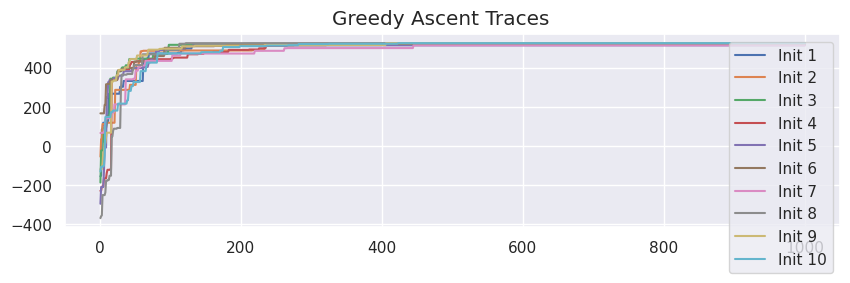

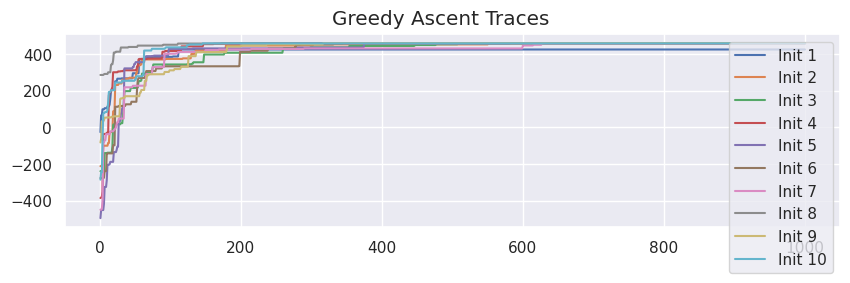

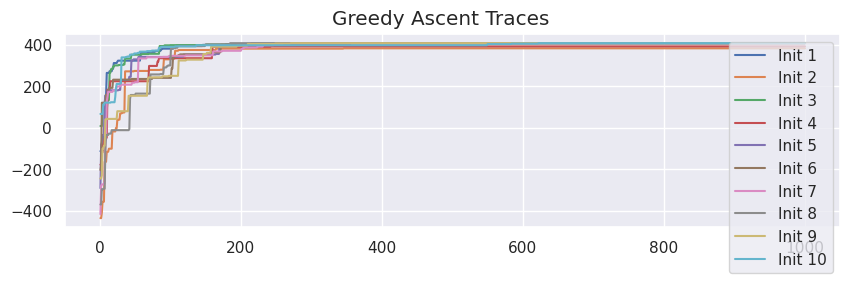

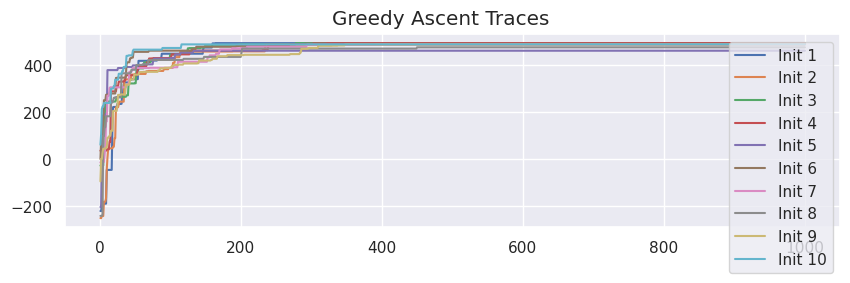

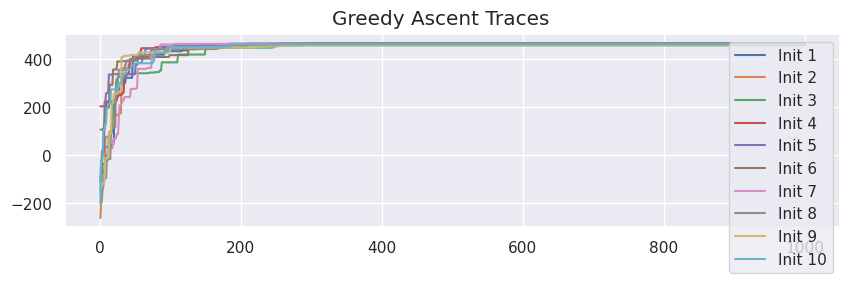

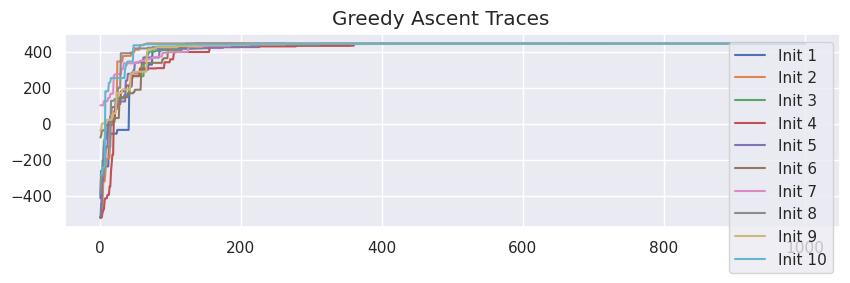

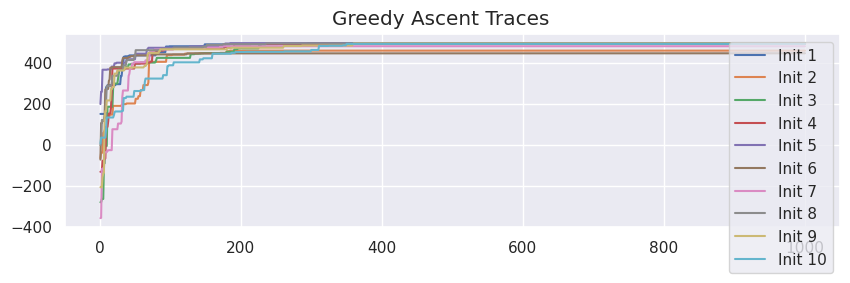

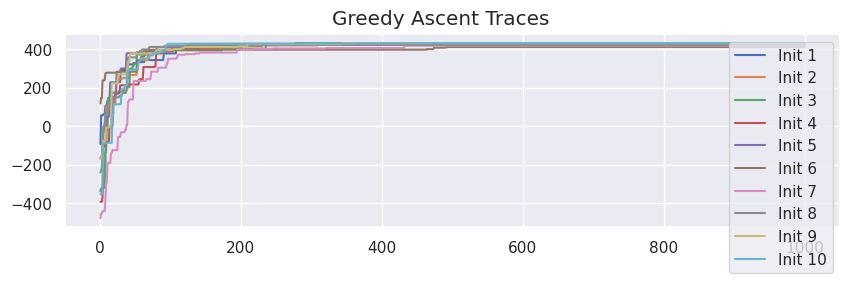

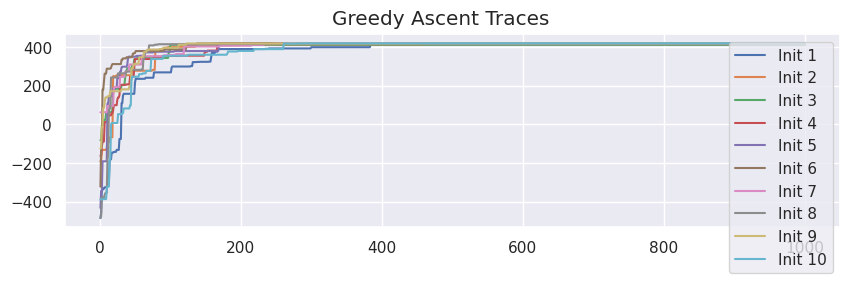

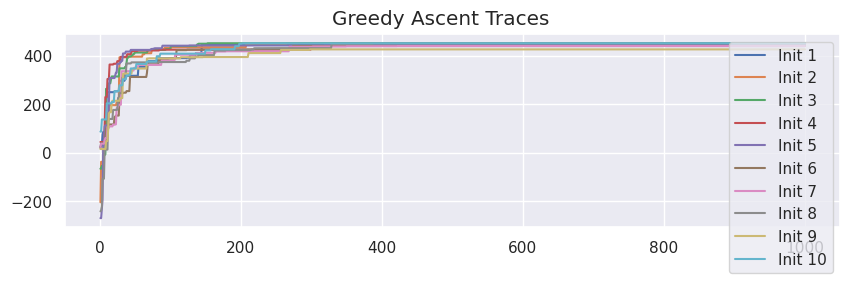

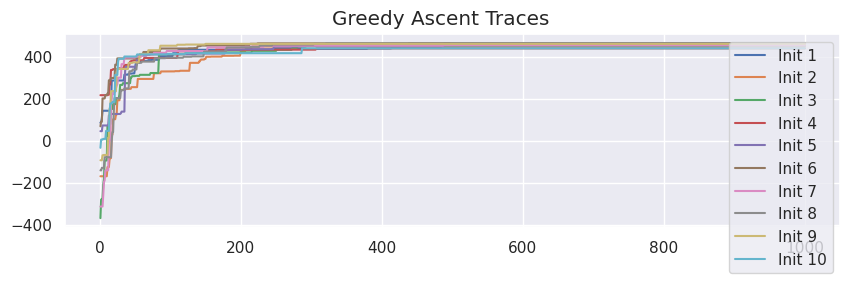

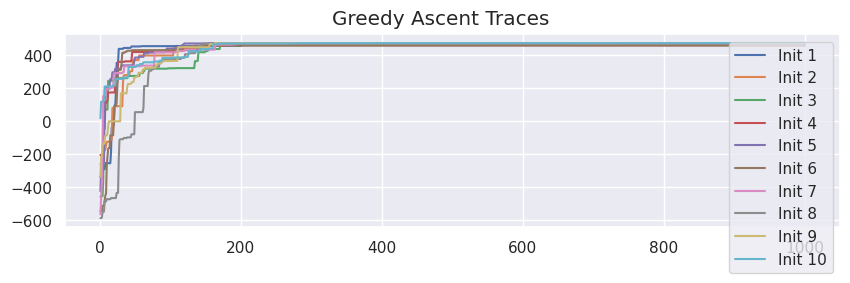

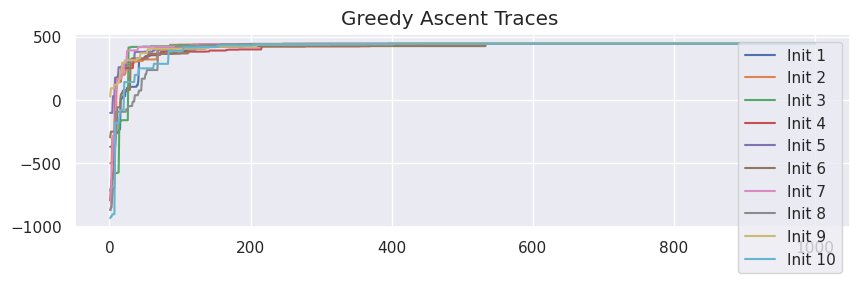

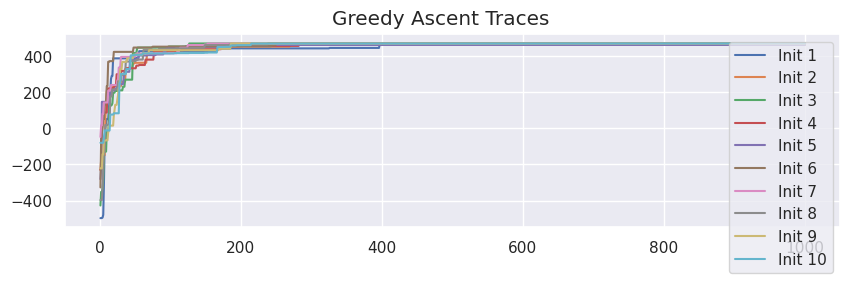

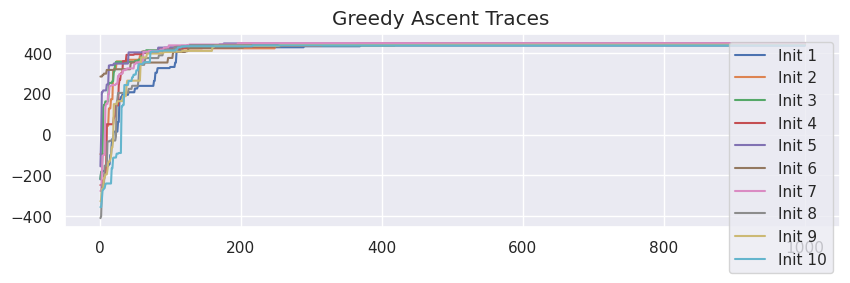

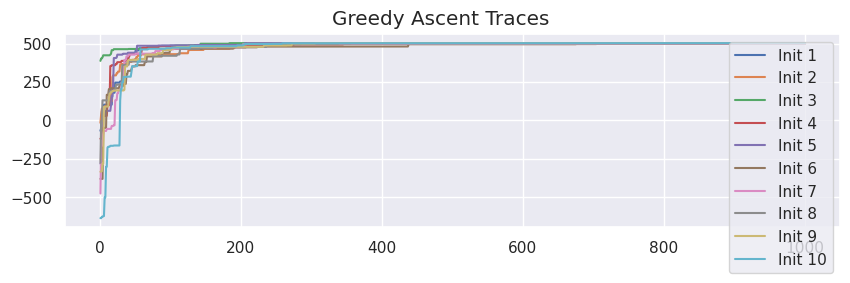

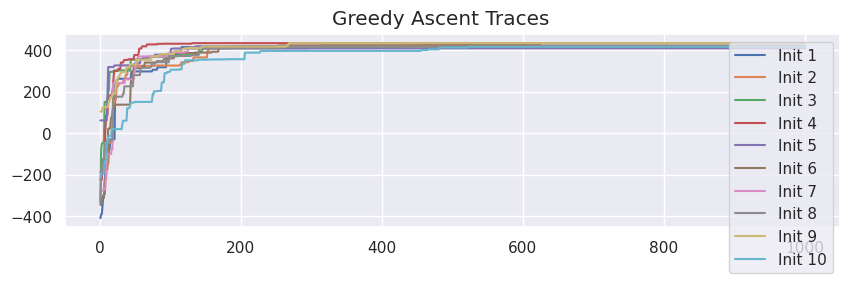

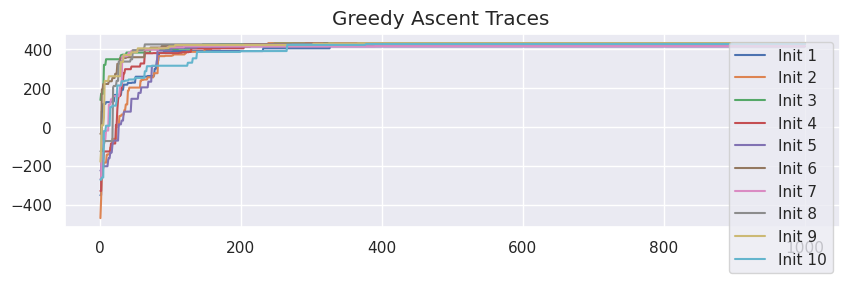

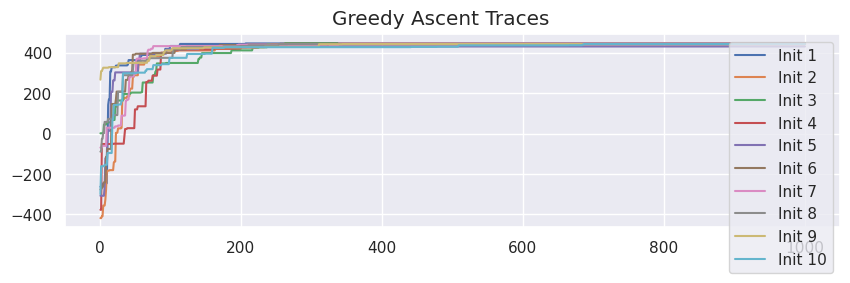

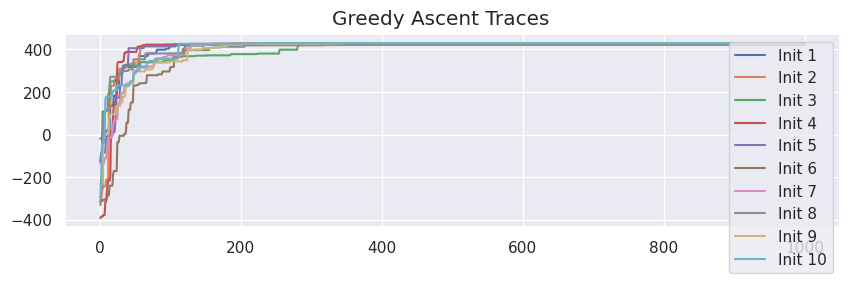

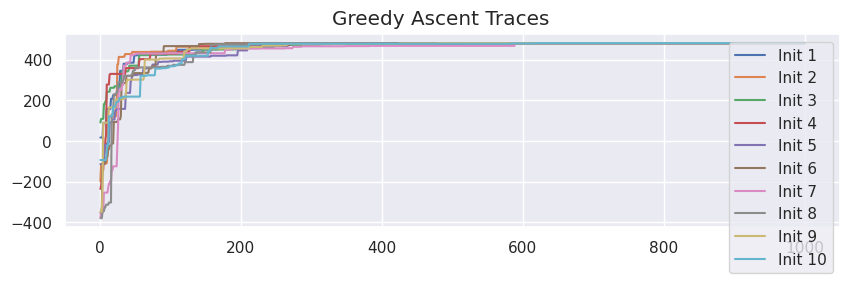

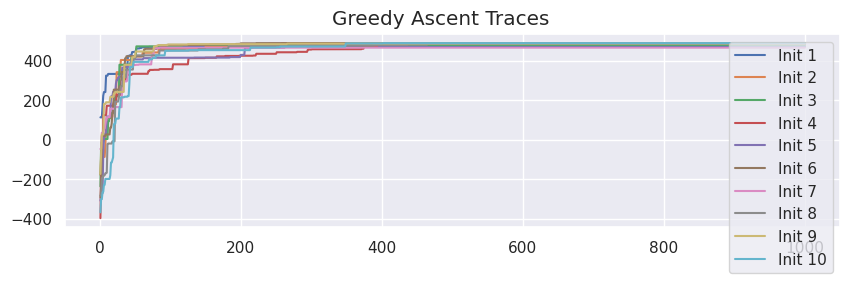

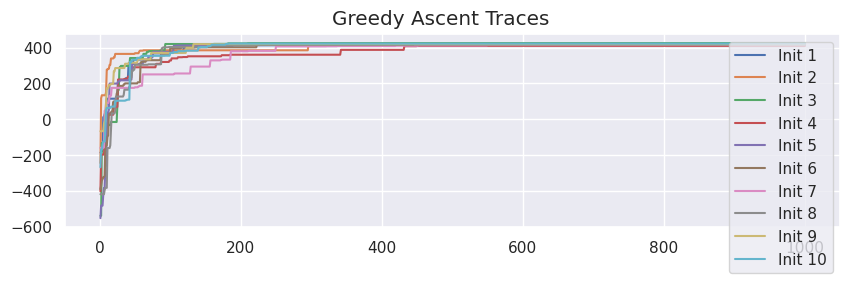

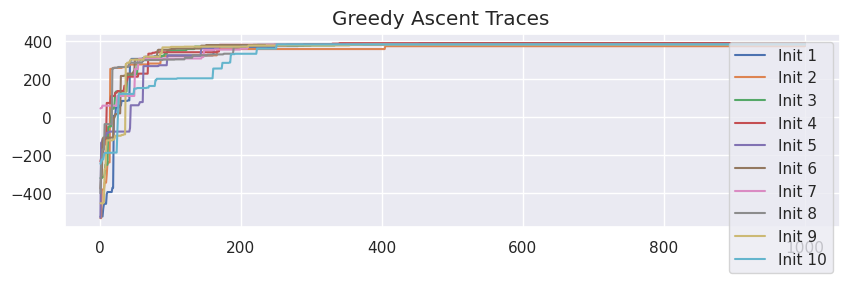

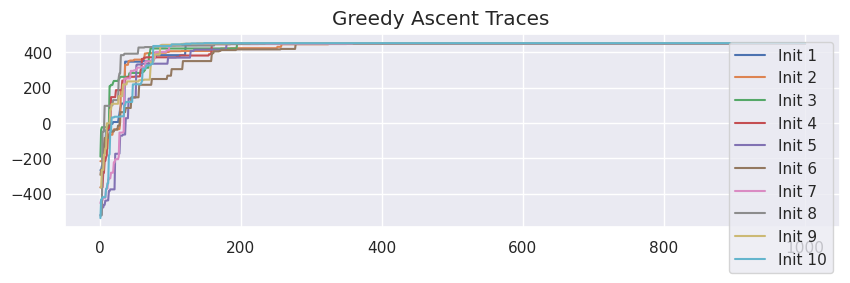

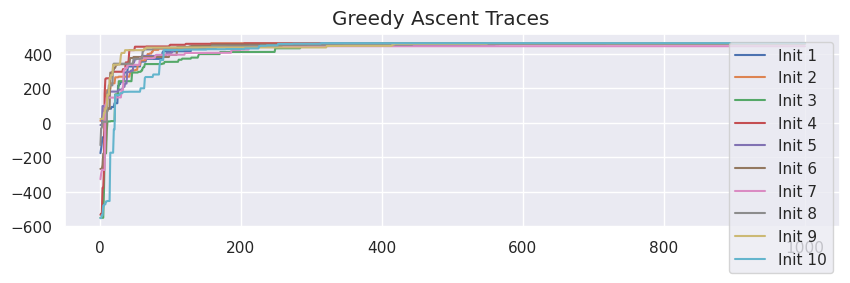

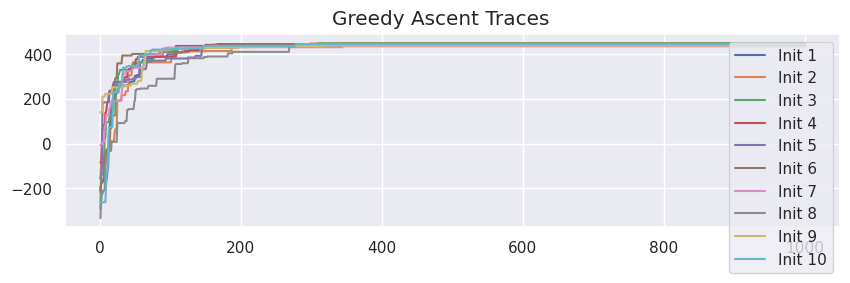

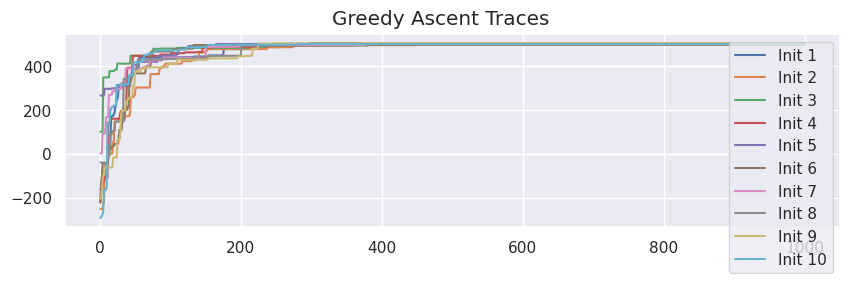

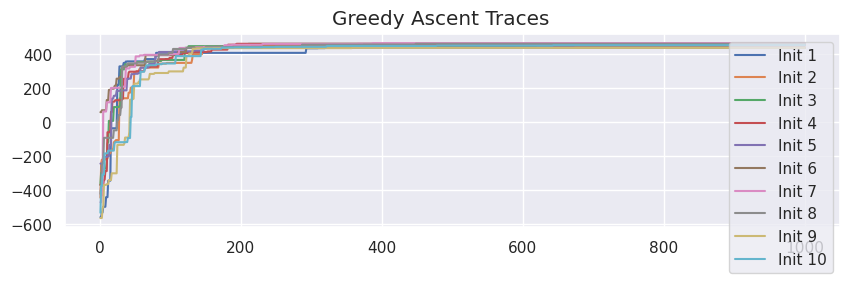

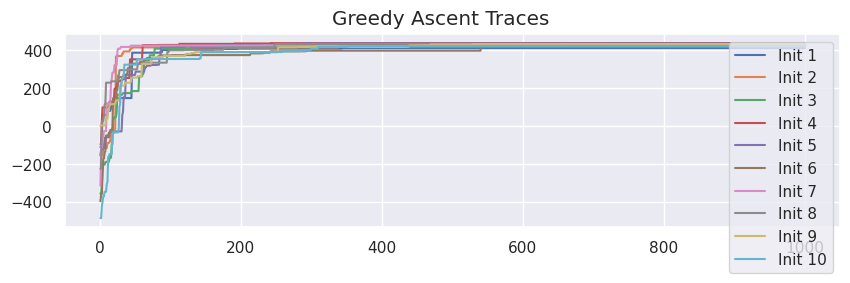

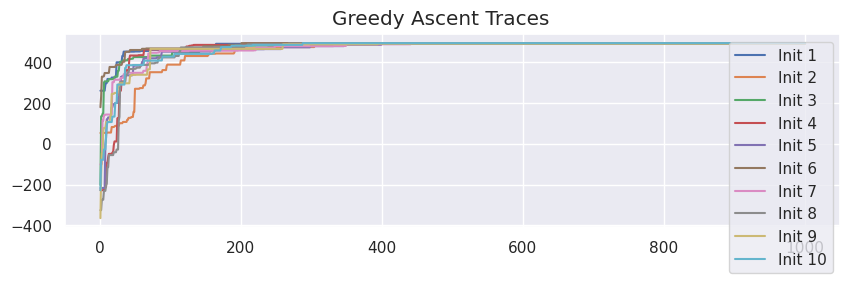

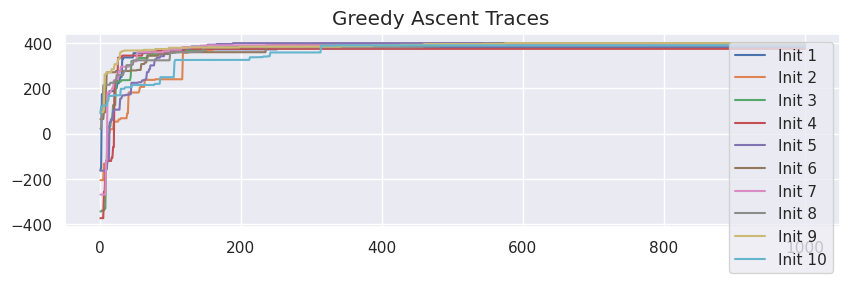

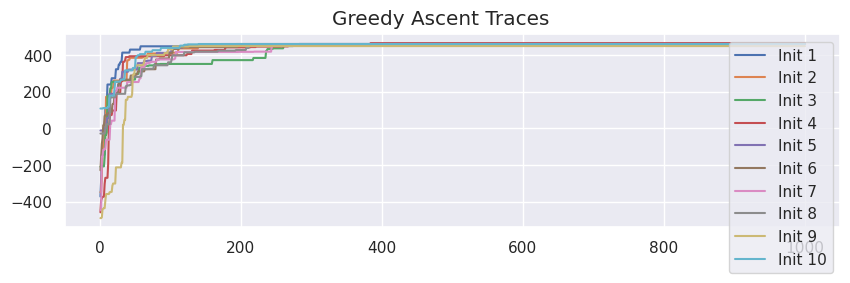

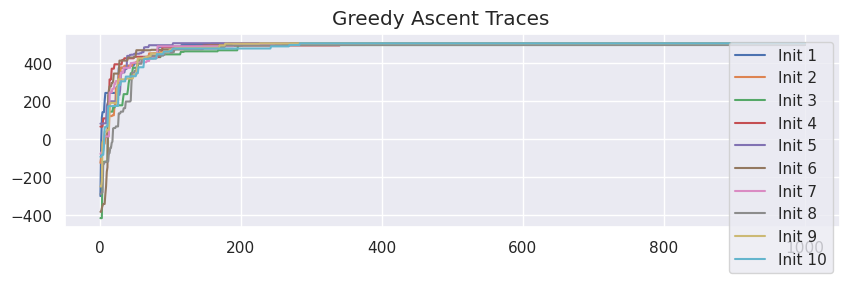

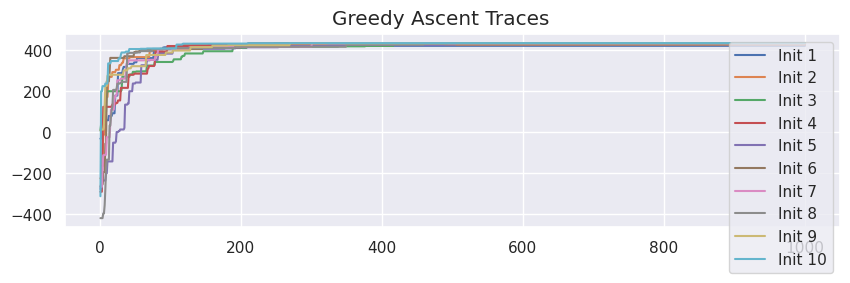

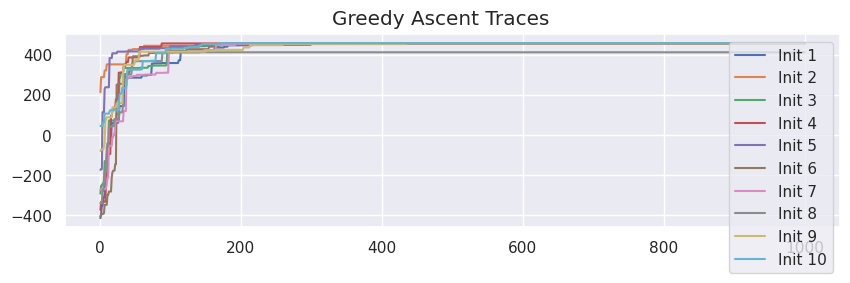

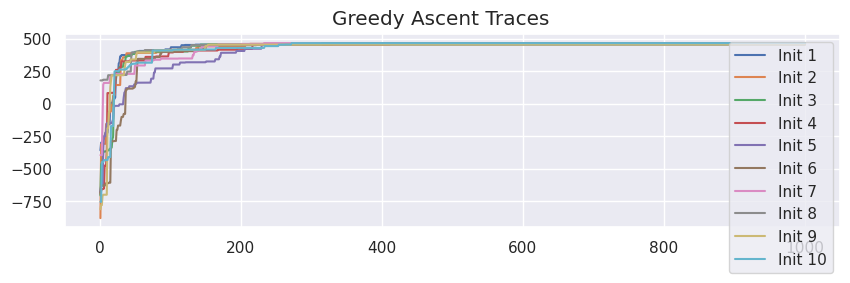

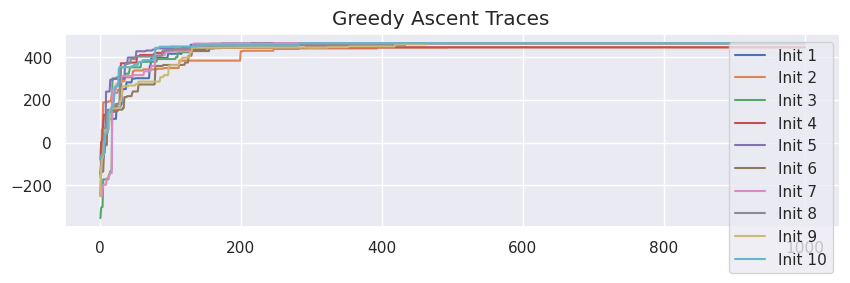

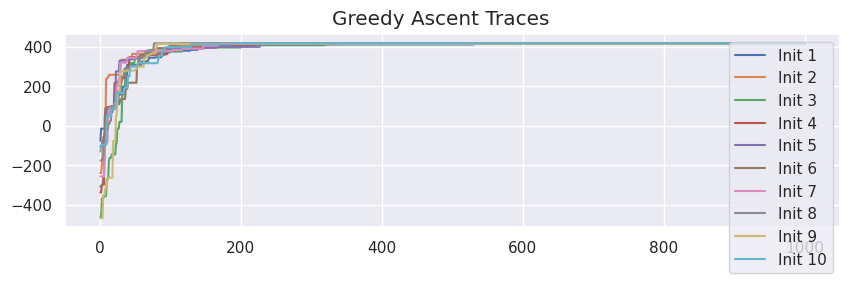

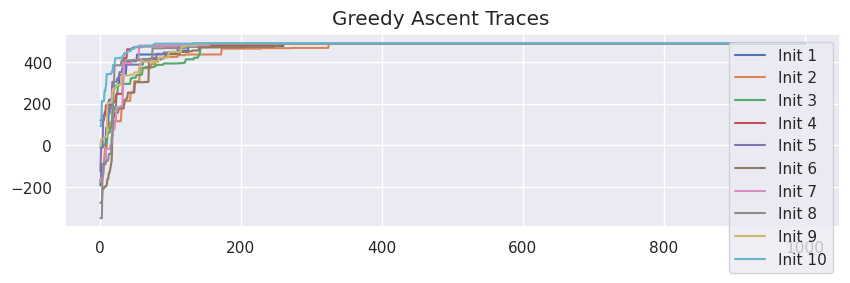

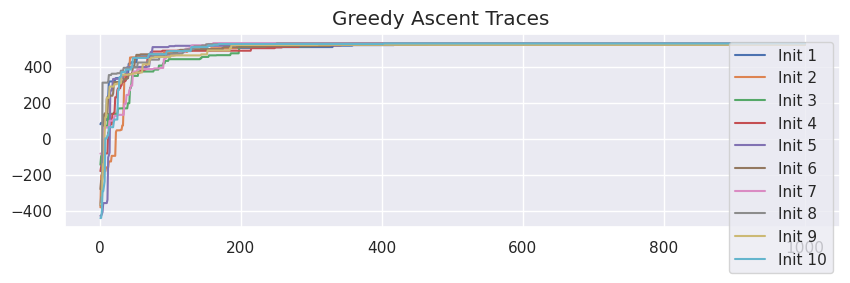

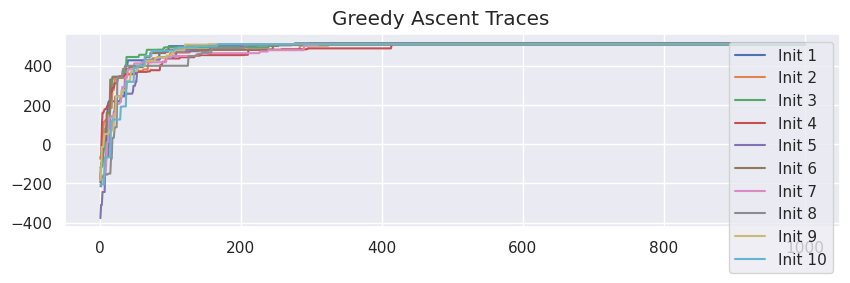

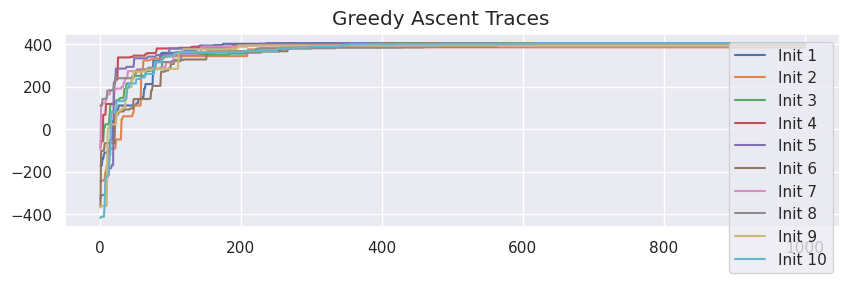

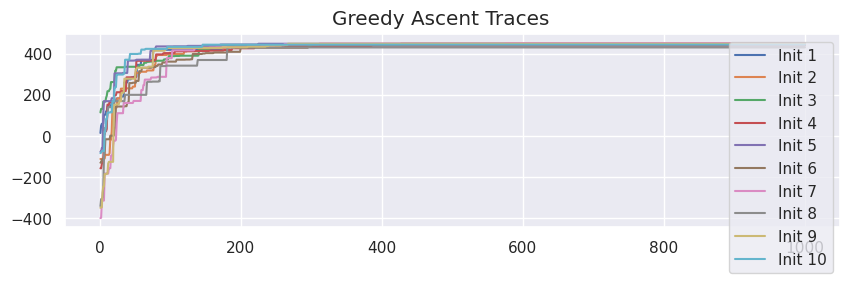

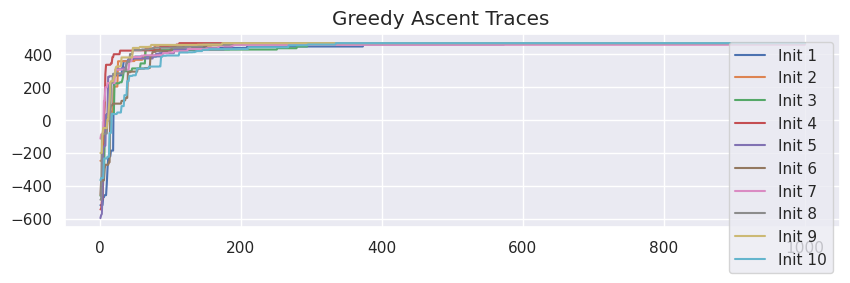

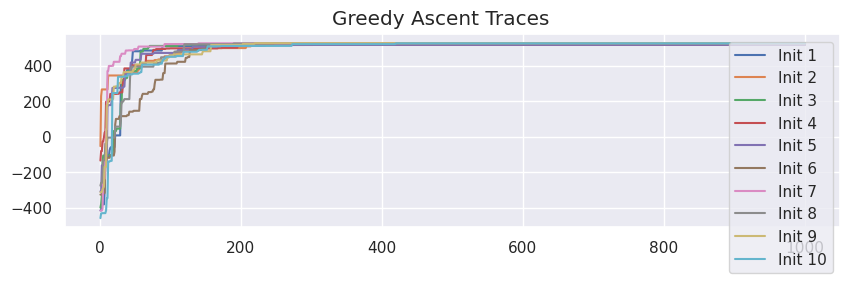

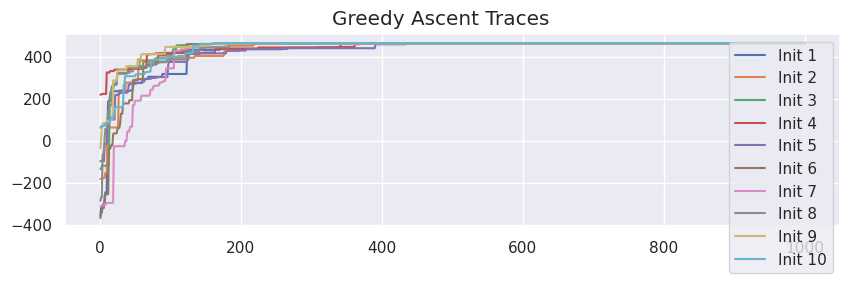

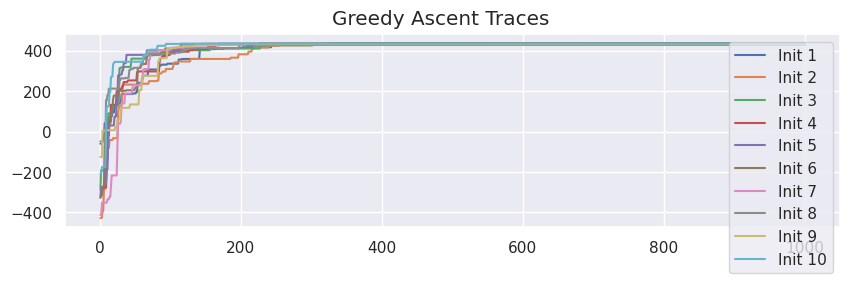

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold
#* RCV1: Repeated, stratified 5-fold CV - uses ML stage as ground truth for test folds
k_folds = 5
n_repeats = 10

#Sets up the random folds to be used in cross-validation. This just states which folds
#each individual belongs to.
repeated_cvfolds = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats) #, random_state=36851234)

# Have we already run the EBM?
if 'ebm_results' in locals():
    check = True
else:
    check = False

#And if we have, have we already run the cross-validation? We can save some time
#if we already have. Otherwise, we will need to run it.
if check:
    if "kde_mixtures_rcv" in ebm_results:
        kde_mixtures_rcv = ebm_results["kde_mixtures_rcv"]
        kde_mcmc_samples_rcv = ebm_results["kde_mcmc_samples_rcv"]
        kde_seqs_rcv = ebm_results["kde_sequences_rcv"]
        kde_staging_errors_rcv = ebm_results["kde_staging_errors_rcv"]
        runit = False
    else:
        runit = True
else:
    runit = True

if runit:
    kde_mixtures_rcv, kde_mcmc_samples_rcv, kde_seqs_rcv, kde_staging_errors_rcv = kde_utils.ebm_2_repeatedcv(
        x=biomarkers,
        y=dx_labels,
        events=feats,
        rcv_folds=repeated_cvfolds,
        implement_fixed_controls=True,
        patholog_dirn_array=event_disease_direction,
        model_stage=kde_stages_long
    )
    #* Save
    ebm_results["kde_mixtures_rcv"] = kde_mixtures_rcv
    ebm_results["kde_mcmc_samples_rcv"] = kde_mcmc_samples_rcv
    ebm_results["kde_sequences_rcv"] = kde_seqs_rcv
    ebm_results["kde_staging_errors_rcv"] = kde_staging_errors_rcv
    # pickle_file = open(pickle_path,'wb')
    # pickle_output = pickle.dump(ebm_results, pickle_file)
    # pickle_file.close()

## Plot KDE CV Positional Variance Diagram

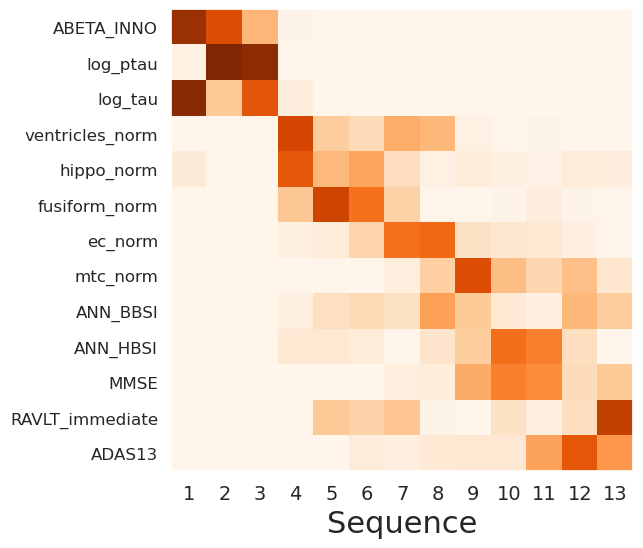

In [18]:
pvd_rcv, seq_rcv = kde_utils.extract_pvd(ml_order=kde_seqs_rcv,samples=kde_mcmc_samples_rcv)
reorder_rcv = np.argsort(seq_rcv)
pvd_rcv_ = pvd_rcv[:][reorder_rcv]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
ax.imshow(pvd_rcv_[:][seq_rcv], interpolation='nearest', cmap='Oranges')
# ax.set_title('Cross-Validation',fontsize=24)

n_biomarkers = pvd_rcv.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0)
ax.tick_params(axis='y',color='w')
ax.set_yticklabels(feats,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=12)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Sequence', fontsize=22)
ax.grid(False)